# Taller 1 - Datos funcionales

## Librerías

In [1]:
import os
import warnings
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import skfda
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.exploratory.stats import mean, trim_mean, cov, depth_based_median
from skfda.exploratory.depth import ModifiedBandDepth, BandDepth
from tqdm import tqdm
from skfda.exploratory.visualization import Boxplot

# Suppress warnings
warnings.filterwarnings("ignore")


## Cargar los datos

In [2]:
# Load MATLAB data
archivo_mat = "../Datos/data.mat"
datos = sio.loadmat(archivo_mat)

# Reshape data 
# Dimensions: 268 tests x 571 measurement points x 7 wavelengths
data = datos["X"].reshape(268, 571, 7, order='F')

# Wavelength labels
wavelengths = {
    0: 'Y1=230', 1: 'Y2=240', 2: 'Y3=255', 
    3: 'Y4=290', 4: 'Y5=305', 5: 'Y6=325', 6: 'Y7=340'
}

# Measurement points grid
dominio = np.arange(275, 560.5, 0.5)

# longitud de onda a trabajar
wavelength_idx = 6

## Visualization of Raw Data

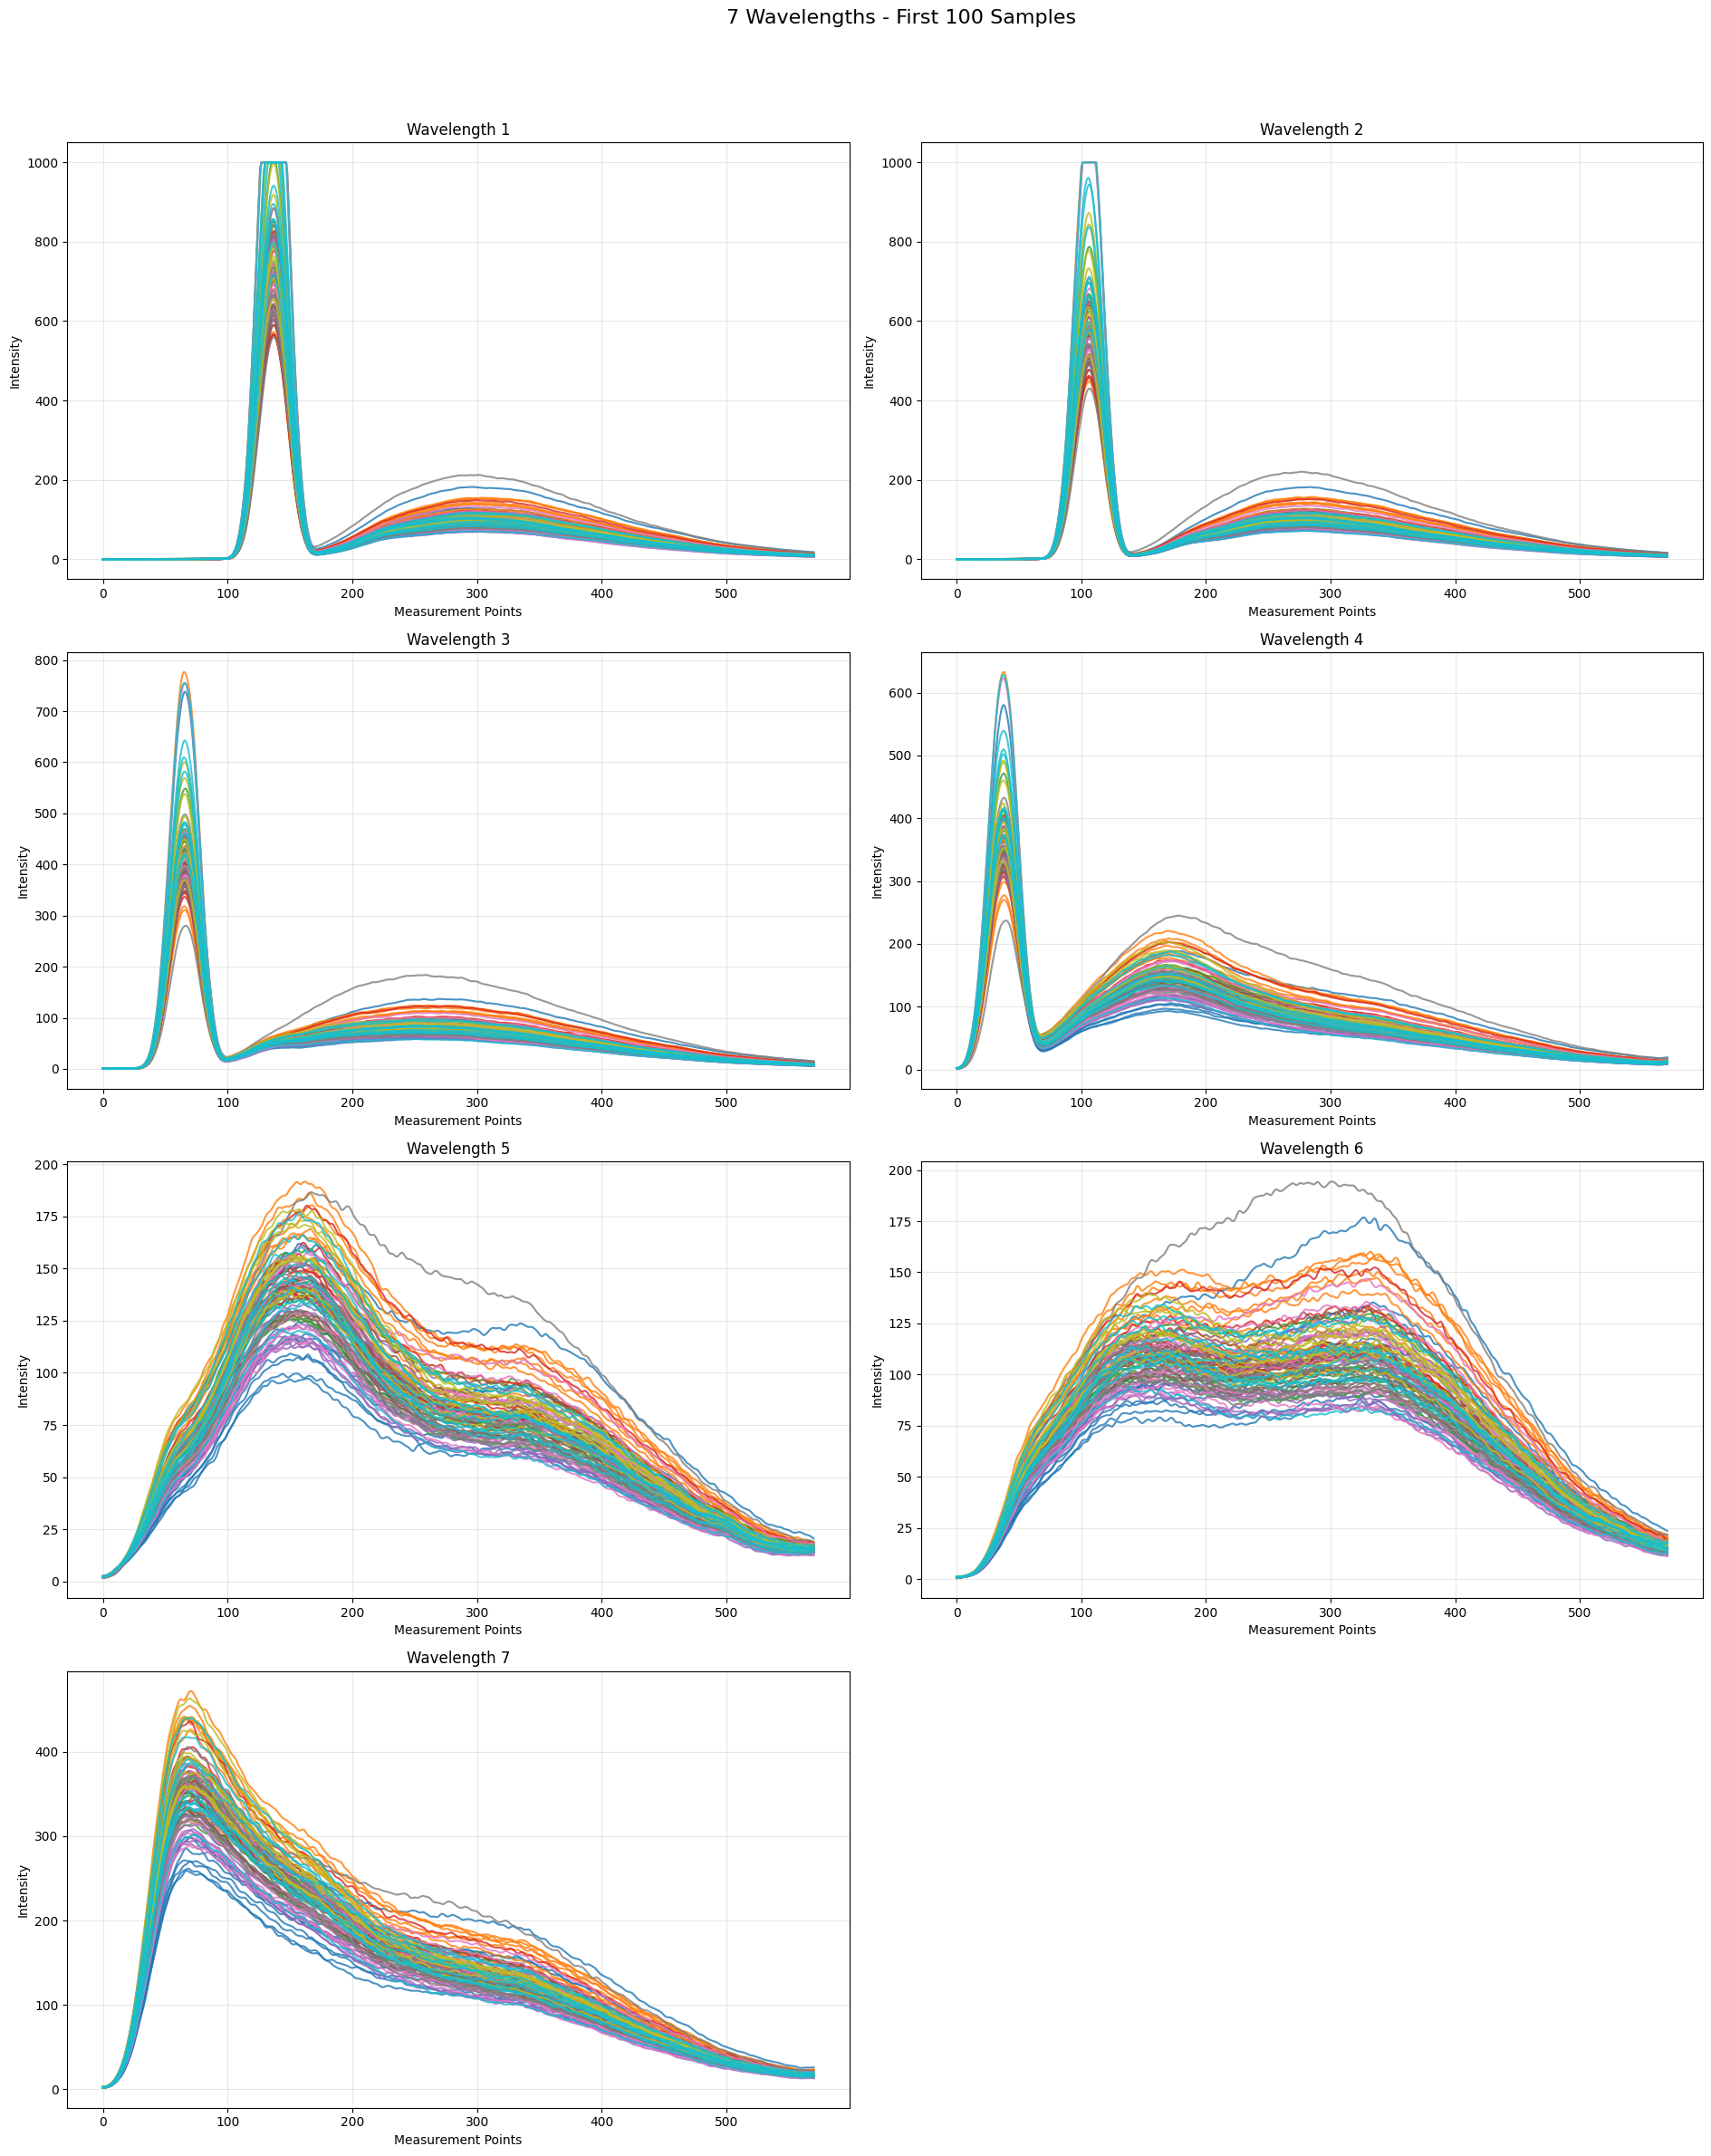

In [3]:
def plot_wavelength_data(organizado, n_samples=100):
    """
    Plot intensity data for first n_samples across 7 wavelengths
    """
    colors = plt.cm.tab10(np.linspace(0, 1, n_samples))
    fig, axes = plt.subplots(4, 2, figsize=(20, 25))
    fig.suptitle('7 Wavelengths - First 100 Samples', fontsize=16)
    
    axes = axes.ravel()
    x = np.arange(571)
    
    for wavelength in range(7):
        for sample in range(n_samples):
            data = organizado[sample, :, wavelength]
            axes[wavelength].plot(x, data, color=colors[sample], 
                                   linewidth=1.5, alpha=0.8)
        
        axes[wavelength].set_title(f'Wavelength {wavelength+1}', fontsize=12)
        axes[wavelength].set_xlabel('Measurement Points')
        axes[wavelength].set_ylabel('Intensity')
        axes[wavelength].grid(True, alpha=0.3)
    
    axes[-1].set_visible(False)
    plt.tight_layout(rect=[0, 0.03, 0.95, 0.95])
    plt.show()

plot_wavelength_data(data)

## 1.1 Suavizado spline

Hay un total de 1876 curvas a procesar


Procesando muestras:   0%|          | 0/5 [00:00<?, ?it/s]

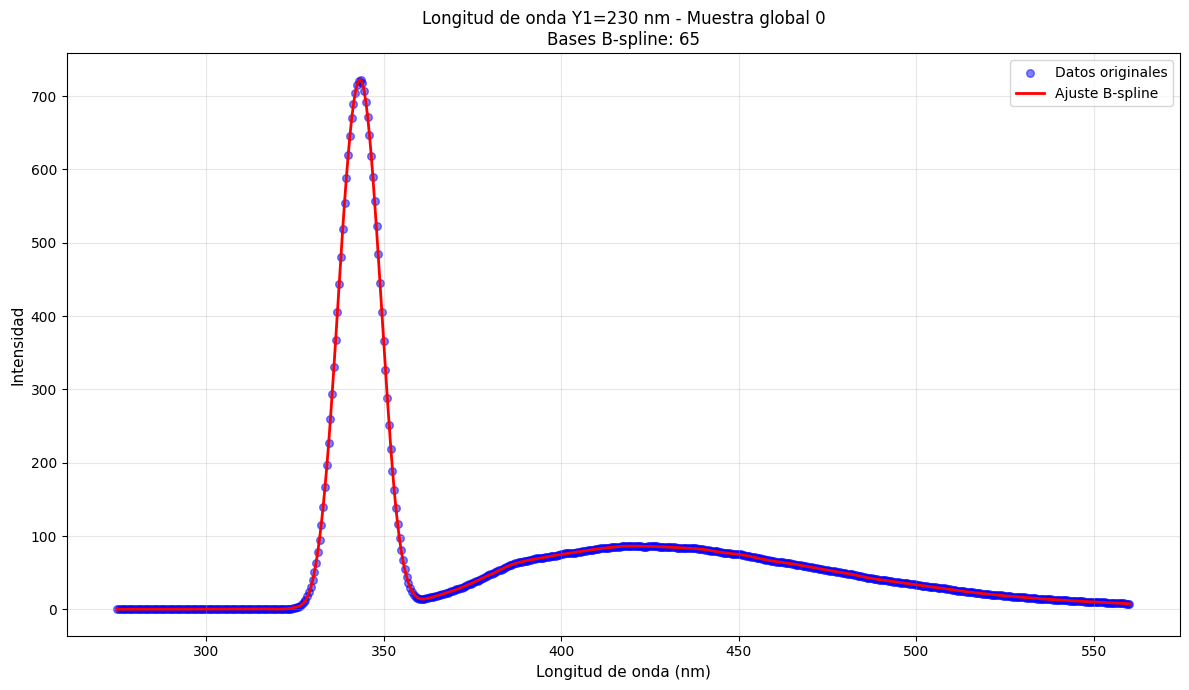

Procesando muestras:  20%|██        | 1/5 [00:01<00:07,  1.91s/it]

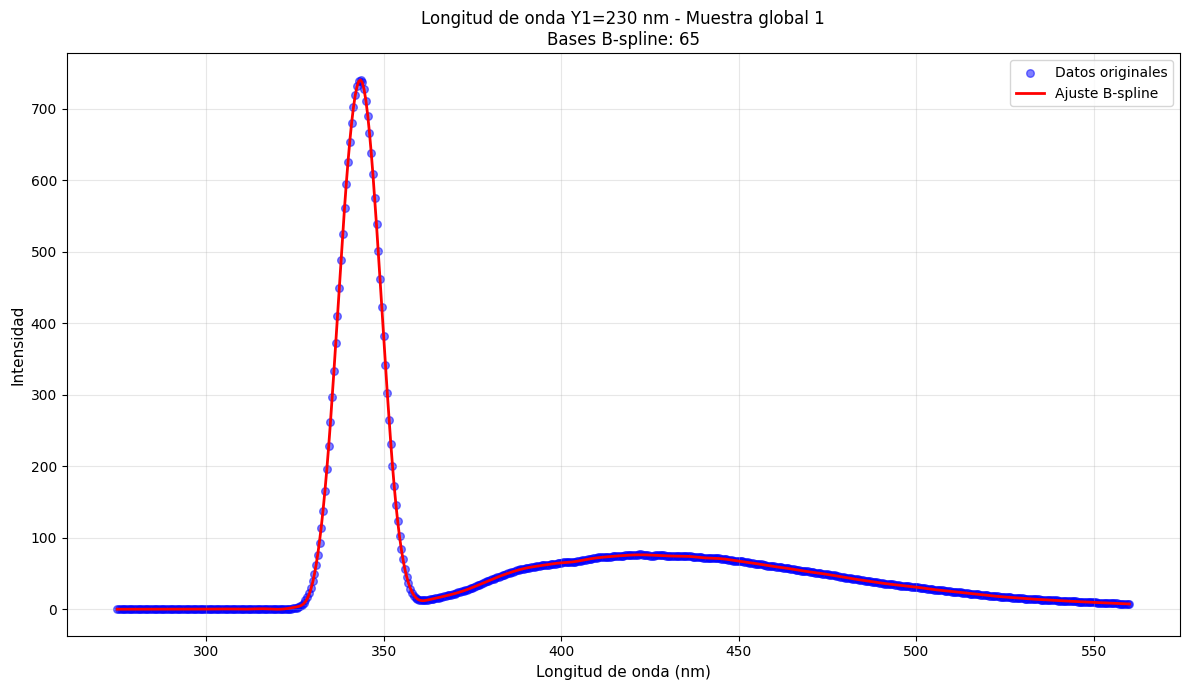

Procesando muestras:  40%|████      | 2/5 [00:03<00:05,  1.88s/it]

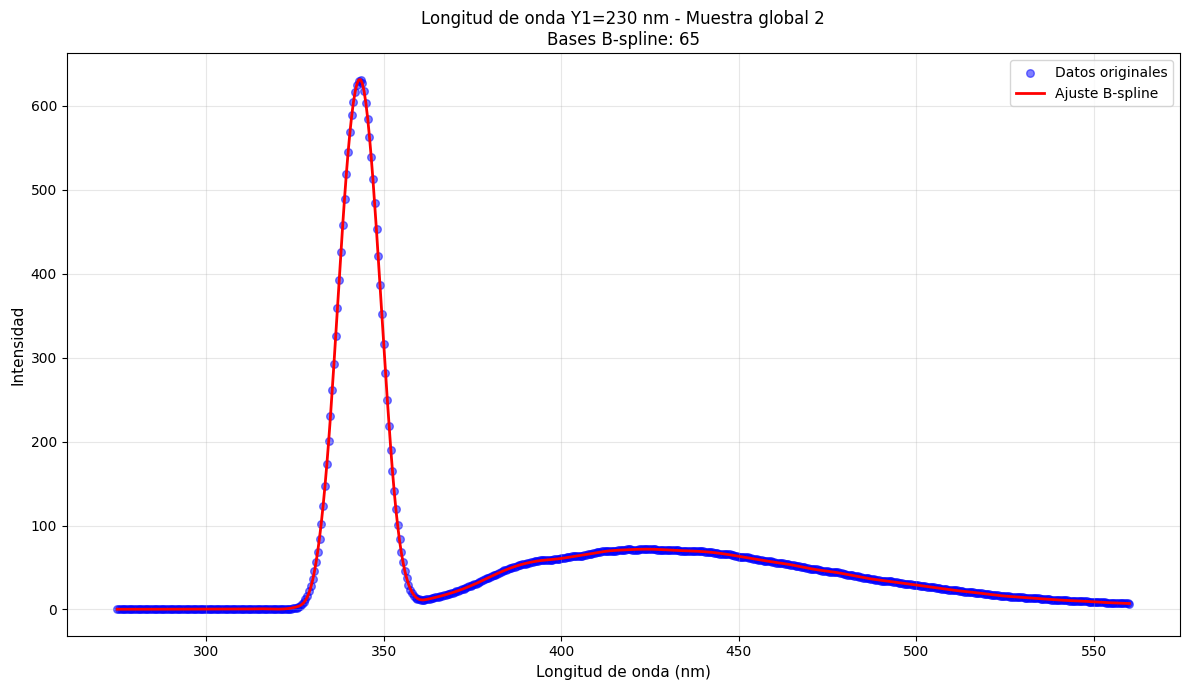

Procesando muestras:  60%|██████    | 3/5 [00:05<00:03,  1.91s/it]

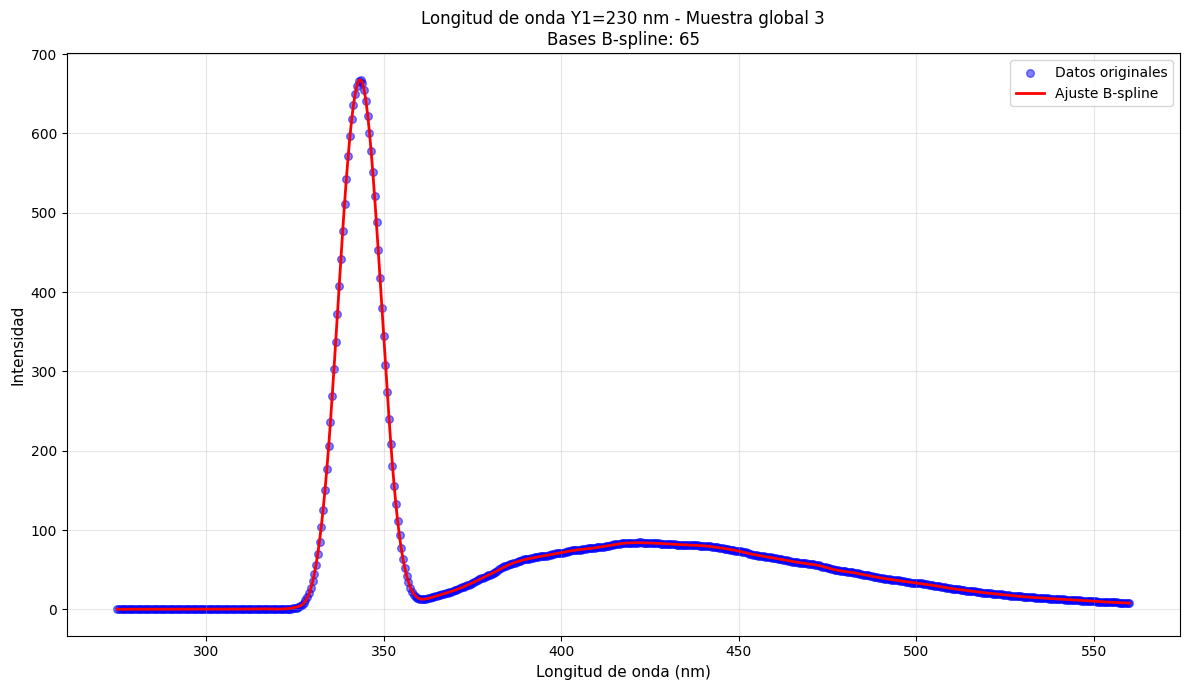

Procesando muestras:  80%|████████  | 4/5 [00:07<00:02,  2.05s/it]

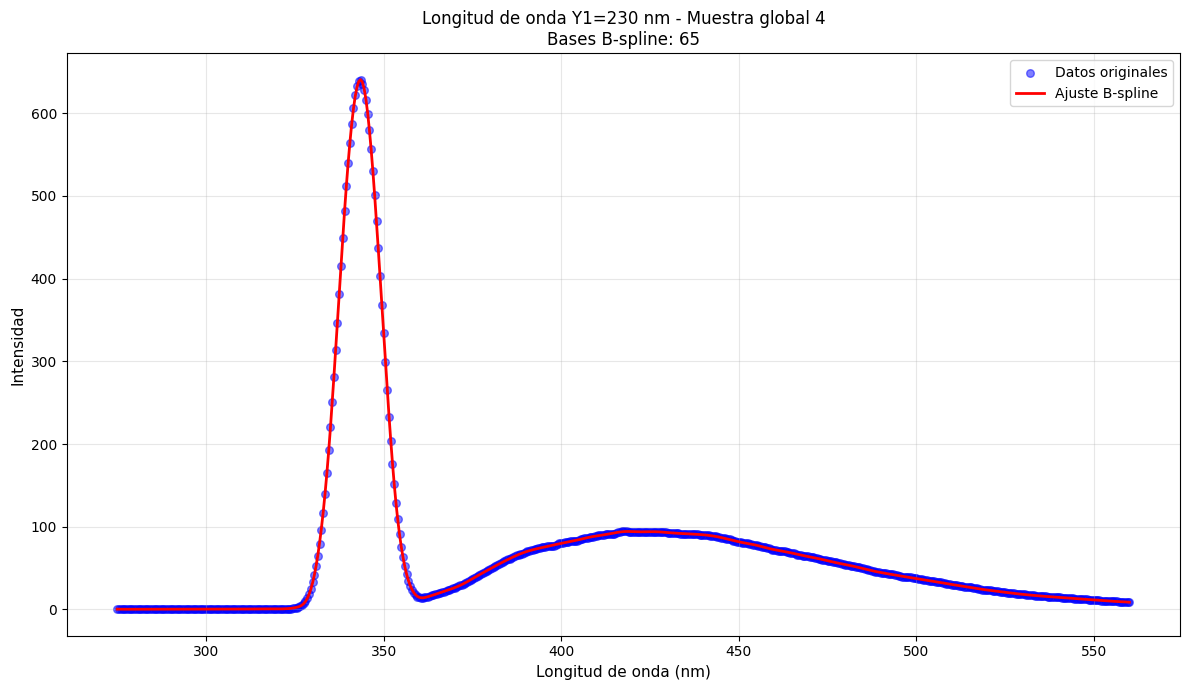

Procesando muestras: 100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

Proceso completado. Se han generado todas las imágenes con el ajuste penalizado.


In [4]:
def smooth_functional_data(
    data, 
    wavelengths, 
    dominio, 
    base_path="../Resultados/punto_1", 
    n_basis=65, 
    best_param=1e-3, 
    rango_curvas=[None, None],
    mostrar_imagen_cada=None  
):
    """
    Perform functional data smoothing for specified range of samples and wavelengths
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data array with dimensions (n_samples, n_points, n_wavelengths)
    wavelengths : dict
        Dictionary of wavelengths
    dominio : array-like
        Domain points for the data
    base_path : str, optional
        Base directory to save results
    n_basis : int, optional
        Number of B-Spline basis functions
    best_param : float, optional
        Smoothing parameter (lambda)
    rango_curvas : list, optional
        Range of curves to process [start, end]. 
        If None, processes all curves. 
        Indices are 0-based.
    mostrar_imagen_cada : int or None, optional
        Show an image every 'n' processed samples.
        If None, no images are shown during processing.
    """
    # Crear la estructura de carpetas base
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Crear subcarpetas para cada longitud de onda
    for wave_idx, wave_name in wavelengths.items():
        wave_path = os.path.join(base_path, wave_name)
        if not os.path.exists(wave_path):
            os.makedirs(wave_path)

    # Determinar el rango de curvas a procesar
    inicio = rango_curvas[0] if rango_curvas[0] is not None else 0
    fin = rango_curvas[1] if rango_curvas[1] is not None else 5  

    # Crear una barra de progreso
    total_iterations = fin - inicio
    with tqdm(total=total_iterations, desc="Procesando muestras") as pbar:
        # Contador de muestras procesadas
        muestras_procesadas = 0

        # Para cada longitud de onda
        for wave_idx, wave_name in wavelengths.items():
            # Si ya hemos procesado todas las muestras requeridas, salir del bucle
            if muestras_procesadas >= fin:
                break

            # Procesar muestras para esta longitud de onda
            for muestra in range(data.shape[0]):
                # Si ya hemos procesado todas las muestras requeridas, salir del bucle
                if muestras_procesadas >= fin:
                    break

                # Obtener los datos para esta muestra y longitud de onda
                X = data[muestra, :, wave_idx].flatten()
                
                # Crear una base B-Spline
                basis = BSplineBasis(domain_range=(275, 560), n_basis=n_basis)
                
                # Crear functional data grid
                fd = skfda.FDataGrid(data_matrix=X, grid_points=dominio)
                
                # Suavizado penalizado
                smoother = BasisSmoother(basis, smoothing_parameter=best_param)
                fd_smoothed = smoother.fit_transform(fd)
                
                # Decidir si mostrar la imagen
                if mostrar_imagen_cada is not None and muestras_procesadas % mostrar_imagen_cada == 0:
                    # Crear la figura
                    plt.figure(figsize=(12, 7))
                    
                    # Graficar los datos originales como puntos
                    plt.scatter(dominio, X, c='blue', s=30, alpha=0.5, label='Datos originales')
                    
                    # Graficar la curva ajustada
                    plt.plot(dominio, fd_smoothed(dominio)[0], 'r-',
                             label=f'Ajuste B-spline',
                             linewidth=2)
                    
                    # Personalización del gráfico
                    plt.title(f'Longitud de onda {wave_name} nm - Muestra global {muestra}\n'
                              f'Bases B-spline: {n_basis}', fontsize=12)
                    plt.xlabel('Longitud de onda (nm)', fontsize=11)
                    plt.ylabel('Intensidad', fontsize=11)
                    plt.legend(fontsize=10)
                    plt.grid(True, alpha=0.3)
                    
                    # Ajustar los márgenes
                    plt.tight_layout()
                    
                    # Mostrar la figura
                    plt.show()
                
                # Crear la figura para guardar
                plt.figure(figsize=(12, 7))
                
                # Graficar los datos originales como puntos
                plt.scatter(dominio, X, c='blue', s=30, alpha=0.5, label='Datos originales')
                
                # Graficar la curva ajustada
                plt.plot(dominio, fd_smoothed(dominio)[0], 'r-',
                         label=f'Ajuste B-spline',
                         linewidth=2)
                
                # Personalización del gráfico
                plt.title(f'Longitud de onda {wave_name} nm - Muestra global {muestra}\n'
                          f'Bases B-spline: {n_basis}', fontsize=12)
                plt.xlabel('Longitud de onda (nm)', fontsize=11)
                plt.ylabel('Intensidad', fontsize=11)
                plt.legend(fontsize=10)
                plt.grid(True, alpha=0.3)
                
                # Ajustar los márgenes
                plt.tight_layout()
                
                # Guardar la figura
                output_path = os.path.join(
                    base_path,
                    wave_name,
                    f'onda_{wave_idx}_muestra_global_{muestra}.png'
                )
                plt.savefig(output_path, dpi=300, bbox_inches='tight')
                plt.close()
                
                # Incrementar el contador de muestras procesadas
                muestras_procesadas += 1
                
                # Actualizar la barra de progreso
                pbar.update(1)

    print("Proceso completado. Se han generado todas las imágenes con el ajuste penalizado.")

total_curvas = 7*268
print(f'Hay un total de {total_curvas} curvas a procesar')
smooth_functional_data(data, wavelengths, dominio, rango_curvas=[0, 5], mostrar_imagen_cada=1)


## 1.2 

### Estadistica descriptiva funcional

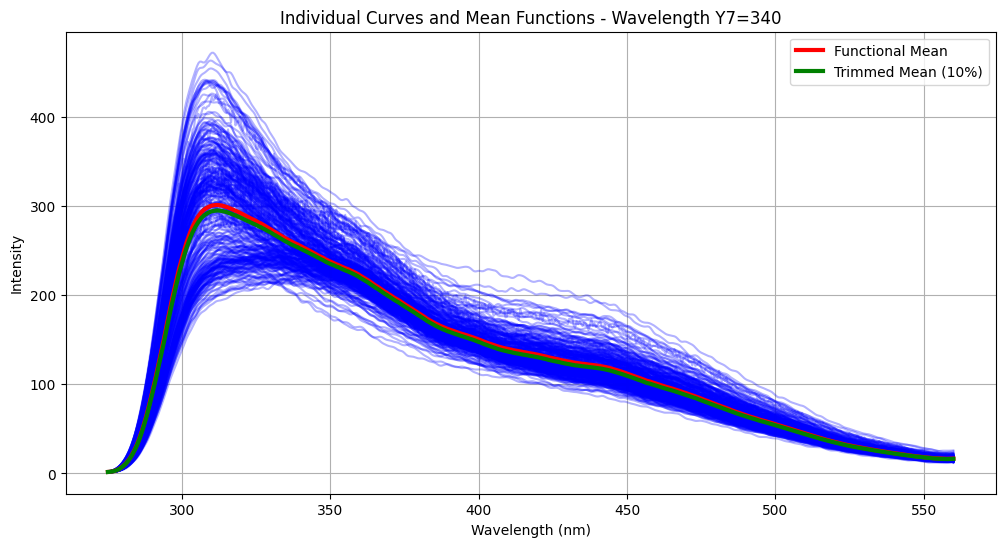

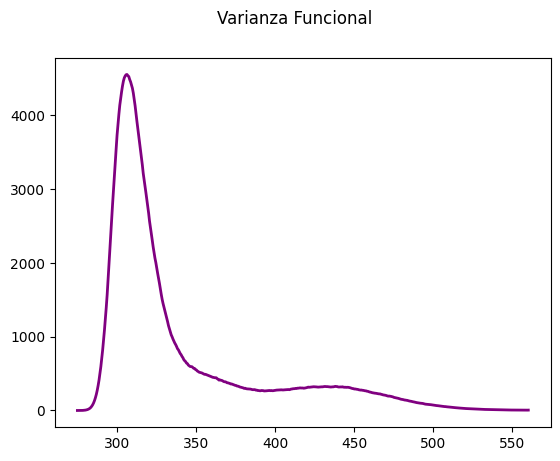

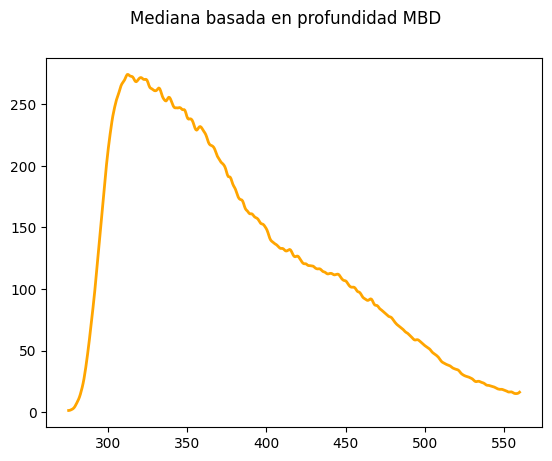

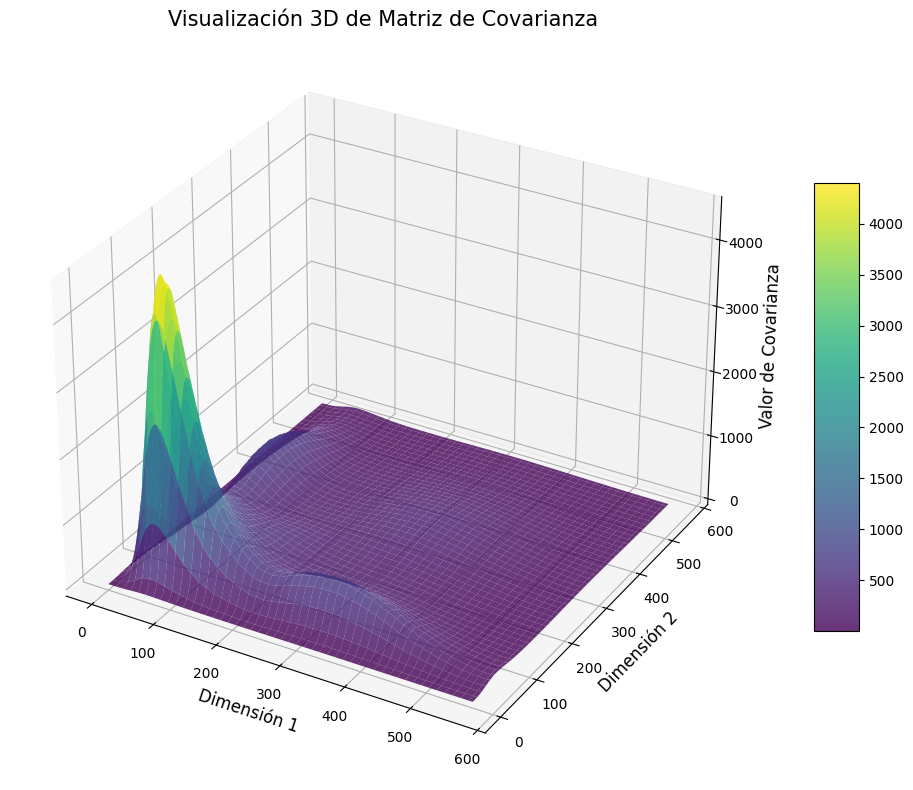

In [5]:
def plot_covariance_3d(cov_matrix):
    """
    Visualiza una matriz de covarianza en un gráfico 3D de superficie.
    
    Parámetros:
    cov_matrix (numpy.ndarray): Matriz de covarianza a visualizar
    """
    # Crear coordenadas para la malla
    x = np.arange(cov_matrix.shape[0])
    y = np.arange(cov_matrix.shape[1])
    X, Y = np.meshgrid(x, y)
    
    # Crear figura y eje 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Graficar la superficie de la matriz de covarianza
    surf = ax.plot_surface(X, Y, cov_matrix, 
                           cmap='viridis',  # Puedes cambiar el colormap
                           edgecolor='none',
                           alpha=0.8)
    
    # Personalizar el gráfico
    ax.set_title('Visualización 3D de Matriz de Covarianza', fontsize=15)
    ax.set_xlabel('Dimensión 1', fontsize=12)
    ax.set_ylabel('Dimensión 2', fontsize=12)
    ax.set_zlabel('Valor de Covarianza', fontsize=12)
    
    # Añadir una barra de color
    fig.colorbar(surf, shrink=0.6, aspect=10)
    
    plt.tight_layout()
    plt.show()
    
def functional_stats_analysis(data, wavelength_idx):
    """
    Compute and visualize functional statistics
    """
    X = data[:, :, wavelength_idx]
    fd = skfda.FDataGrid(data_matrix=X, grid_points=dominio)
    
    # Mean computation.
    mean_func = mean(fd)
    mean_trim_func = trim_mean(fd, 0.1)
    
    # Plotting means
    plt.figure(figsize=(12, 6))
    for sample in range(268):
        plt.plot(dominio, X[sample], color="blue", linewidth=1.5, alpha=0.3)
    
    plt.plot(dominio, np.mean(X, axis=0), color='red', linewidth=3, label='Functional Mean')
    plt.plot(dominio, mean_trim_func(dominio)[0], color='green', linewidth=3, label='Trimmed Mean (10%)')
    
    plt.title(f'Individual Curves and Mean Functions - Wavelength {wavelengths[wavelength_idx]}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Variance
    var_func = skfda.exploratory.stats.var(fd)
    var_func.dataset_name = f"Varianza Funcional"
    var_func.plot(color='purple', linewidth=2, legend=True)
    
    # Depth-based median
    median_func = depth_based_median(fd)
    median_func.dataset_name = f"Mediana basada en profundidad MBD"
    median_func.plot(color='orange', linewidth=2, legend=True)
    
    # covariance
    covariance = cov(fd, correction = 0)
    cov_matrix = covariance(fd.grid_points[0], fd.grid_points[0])
    plot_covariance_3d(cov_matrix)
    return fd

fd_analysis = functional_stats_analysis(data, wavelength_idx)

## Profundidad y class_outliners

### Analisis de profundidad funcional por BD y MBD

Valores de profundidad ordenados - Método Bd


0      1      2      3      4      5      6      7      8      9    \
26   1.906  2.055  2.294  2.658  3.165  3.816  4.624  5.627  6.872  8.397   
57   1.627  1.808  2.112  2.540  3.078  3.736  4.568  5.617  6.853  8.180   
64   1.891  1.959  2.183  2.578  3.106  3.735  4.483  5.409  6.565  7.970   
123  1.660  1.886  2.191  2.551  2.971  3.490  4.156  4.997  6.023  7.219   
31   1.932  2.032  2.262  2.628  3.111  3.716  4.484  5.459  6.659  8.093   
75   1.995  2.177  2.438  2.816  3.355  4.073  4.958  5.991  7.184  8.602   
36   1.940  2.146  2.480  2.939  3.506  4.160  4.918  5.853  7.059  8.554   
93   1.697  1.802  2.037  2.414  2.909  3.517  4.286  5.269  6.474  7.889   
74   1.872  1.965  2.206  2.622  3.193  3.887  4.725  5.796  7.200  8.970   
59   1.746  1.968  2.299  2.721  3.209  3.767  4.440  5.291  6.367  7.691   
79   1.859  2.115  2.443  2.845  3.349  3.997  4.853  5.999  7.487  9.277   
98   1.642  1.846  2.138  2.532  3.057  3.745  4.602  5.635  6.871  8.334   
32   1.648  1.797  2.060  2.470  3.030  3.702  4.453  5.299  6.303  7.528   
126  1.654  1.893  2.263  2.738  3.276  3.854  4.492  5.245  6.181  7.357   
52   1.743  1.888  2.183  2.645  3.234  3.889  4.607  5.478  6.627  8.100   
35   2.002  2.110  2.362  2.819  3.474  4.247  5.078  5.987  7.047  8.330   
41   1.978  2.146  2.425  2.849  3.412  4.094  4.904  5.885  7.073  8.482   
61   1.933  2.077  2.295  2.618  3.108  3.831  4.806  5.980  7.266  8.621   
34   1.958  2.099  2.325  2.683  3.209  3.897  4.719  5.690  6.880  8.334   
55   1.737  1.982  2.370  2.903  3.561  4.327  5.205  6.205  7.339  8.652   

     ...     562     563     564     565     566     567     568     569  \
26   ...  16.591  16.396  16.286  16.302  16.418  16.553  16.668  16.818   
57   ...  16.564  16.182  15.986  16.019  16.187  16.410  16.766  17.419   
64   ...  16.935  16.715  16.780  17.000  17.185  17.216  17.104  16.953   
123  ...  17.802  17.634  17.488  17.346  17.277  17.372  17.643  18.008   
31   ...  16.733  16.472  16.290  16.276  16.447  16.756  17.160  17.656   
75   ...  16.807  16.785  16.790  16.789  16.796  16.894  17.144  17.467   
36   ...  17.275  17.381  17.550  17.657  17.623  17.511  17.501  17.740   
93   ...  17.627  17.714  17.588  17.368  17.186  17.111  17.178  17.437   
74   ...  16.162  16.119  16.264  16.506  16.724  16.847  16.880  16.900   
59   ...  16.393  16.341  16.243  16.101  15.934  15.793  15.775  15.966   
79   ...  17.132  17.309  17.461  17.541  17.591  17.698  17.946  18.392   
98   ...  16.378  16.411  16.468  16.487  16.494  16.537  16.616  16.702   
32   ...  16.816  16.854  16.888  16.875  16.862  16.961  17.251  17.731   
126  ...  17.201  16.850  16.612  16.590  16.720  16.870  16.992  17.149   
52   ...  16.137  16.129  16.054  15.941  15.900  15.985  16.047  15.816   
35   ...  16.389  16.181  16.098  16.166  16.403  16.771  17.128  17.328   
41   ...  17.442  17.466  17.420  17.310  17.169  17.051  16.997  17.009   
61   ...  17.420  17.296  17.296  17.389  17.489  17.588  17.779  18.159   
34   ...  17.422  17.298  17.194  17.179  17.250  17.391  17.624  17.962   
55   ...  17.794  17.599  17.474  17.416  17.453  17.621  17.890  18.156   

        570       571  
26   17.069  0.046816  
57   18.385  0.042680  
64   16.866  0.041897  
123  18.363  0.039298  
31   18.218  0.038376  
75   17.694  0.037677  
36   18.218  0.036140  
93   17.893  0.035217  
74   16.983  0.034714  
59   16.352  0.034546  
79   19.004  0.033876  
98   16.775  0.033876  
32   18.323  0.033177  
126  17.406  0.033121  
52   15.179  0.032730  
35   17.353  0.032562  
41   17.053  0.032394  
61   18.717  0.032282  
34   18.362  0.032282  
55   18.334  0.032059  

[20 rows x 572 columns]

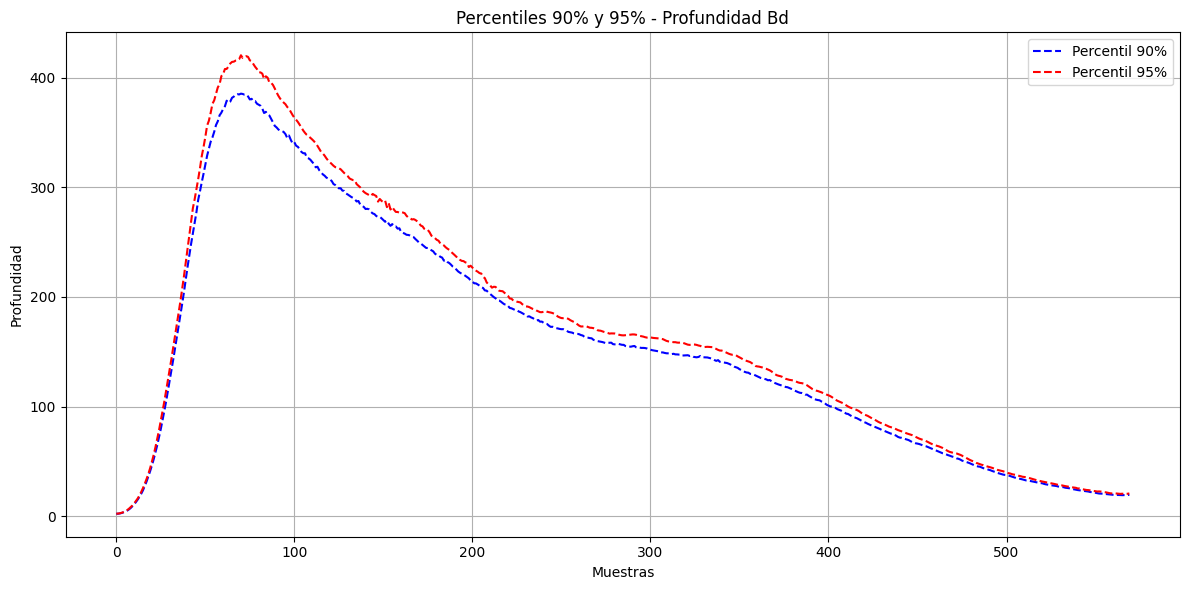

Valores de profundidad ordenados - Método Mbd


0      1      2      3      4      5      6      7      8      9    \
174  1.362  1.439  1.614  1.876  2.189  2.551  3.033  3.726  4.668  5.815   
144  1.462  1.797  1.863  2.483  2.945  3.007  3.613  4.068  4.912  6.689   
78   2.024  2.117  2.277  2.538  2.941  3.516  4.269  5.212  6.386  7.833   
183  1.365  1.445  1.598  1.824  2.124  2.527  3.080  3.813  4.704  5.695   
96   2.079  2.198  2.412  2.761  3.262  3.892  4.627  5.475  6.482  7.715   
43   1.734  1.904  2.129  2.426  2.825  3.367  4.093  5.035  6.202  7.575   
52   1.743  1.888  2.183  2.645  3.234  3.889  4.607  5.478  6.627  8.100   
138  1.529  1.667  1.918  2.315  2.861  3.527  4.268  5.067  5.944  6.945   
27   1.824  2.006  2.313  2.709  3.163  3.705  4.405  5.328  6.501  7.911   
175  1.399  1.476  1.632  1.859  2.154  2.533  3.029  3.665  4.441  5.342   
180  1.989  1.882  1.906  2.129  2.540  3.075  3.680  4.358  5.155  6.111   
65   2.115  2.065  2.121  2.358  2.797  3.392  4.093  4.912  5.915  7.143   
25   2.122  2.153  2.351  2.730  3.247  3.876  4.661  5.678  6.952  8.438   
158  1.452  1.411  1.464  1.722  2.169  3.570  2.911  3.319  5.210  6.077   
22   1.836  2.036  2.395  2.882  3.454  4.125  4.959  5.988  7.185  8.527   
100  2.249  2.330  2.561  2.930  3.398  3.954  4.634  5.509  6.656  8.121   
98   1.642  1.846  2.138  2.532  3.057  3.745  4.602  5.635  6.871  8.334   
181  1.269  1.508  1.783  2.075  2.399  2.791  3.273  3.853  4.547  5.406   
143  1.514  1.655  1.883  2.220  2.676  3.259  3.979  4.830  5.777  6.799   
178  1.723  1.638  1.620  1.738  2.020  2.439  2.950  3.554  4.295  5.205   

     ...     562     563     564     565     566     567     568     569  \
174  ...  15.712  15.364  15.146  15.063  15.070  15.139  15.312  15.672   
144  ...  15.652  16.044  16.044  16.074  17.268  17.211  15.376  15.672   
78   ...  16.231  16.252  16.280  16.320  16.392  16.519  16.751  17.144   
183  ...  15.607  15.488  15.427  15.448  15.538  15.661  15.772  15.848   
96   ...  16.176  16.130  16.258  16.501  16.750  16.876  16.773  16.424   
43   ...  16.413  16.335  16.276  16.220  16.188  16.240  16.438  16.804   
52   ...  16.137  16.129  16.054  15.941  15.900  15.985  16.047  15.816   
138  ...  16.178  16.122  16.134  16.181  16.187  16.185  16.331  16.759   
27   ...  16.060  16.091  16.072  16.111  16.263  16.425  16.424  16.198   
175  ...  16.526  16.405  16.435  16.556  16.617  16.541  16.430  16.450   
180  ...  16.591  16.528  16.421  16.276  16.125  16.002  15.948  15.993   
65   ...  16.268  16.199  16.073  15.990  16.019  16.114  16.116  15.866   
25   ...  16.246  15.890  15.689  15.721  15.980  16.356  16.674  16.796   
158  ...  16.954  16.984  17.875  15.328  16.087  16.912  15.874  16.366   
22   ...  17.130  17.183  17.113  17.008  16.953  16.958  17.018  17.161   
100  ...  16.295  16.342  16.505  16.708  16.874  16.970  17.041  17.168   
98   ...  16.378  16.411  16.468  16.487  16.494  16.537  16.616  16.702   
181  ...  16.897  16.397  16.099  16.144  16.434  16.714  16.705  16.237   
143  ...  16.120  15.983  15.836  15.721  15.659  15.616  15.503  15.260   
178  ...  16.595  16.499  16.396  16.349  16.355  16.338  16.265  16.219   

        570       571  
174  16.221  0.484090  
144  17.251  0.478247  
78   17.677  0.477717  
183  15.905  0.477697  
96   15.916  0.476309  
43   17.301  0.475230  
52   15.179  0.475000  
138  17.422  0.472879  
27   15.850  0.470869  
175  16.646  0.467707  
180  16.126  0.467657  
65   15.351  0.467653  
25   16.705  0.467151  
158  17.390  0.466007  
22   17.398  0.464580  
100  17.381  0.463610  
98   16.775  0.463585  
181  15.372  0.462293  
143  14.920  0.461448  
178  16.294  0.460649  

[20 rows x 572 columns]

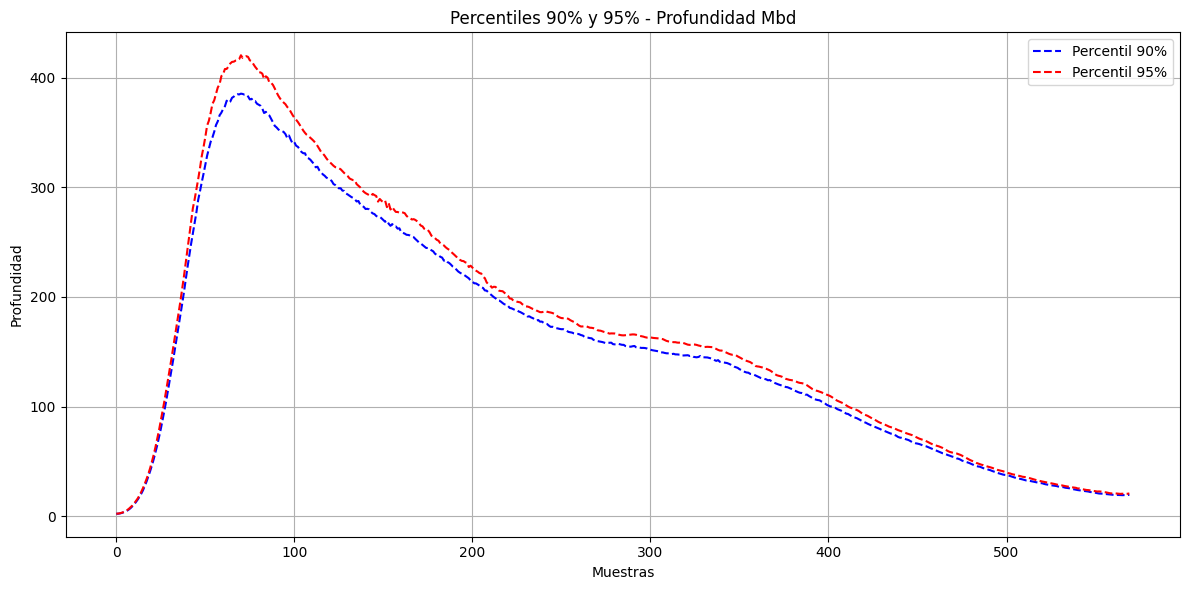

In [6]:
def agregar_valores(data, values, wavelength):
    """
    Agrega un nuevo valor al final de cada fila en la dimensión de wavelength.
    
    Parámetros:
    - data: Array numpy con dimensiones (268, 571, ...)
    - values: Array numpy con dimensiones (268,)
    - wavelength: Índice de la longitud de onda donde se agregará el nuevo valor
    
    Retorna:
    - Nuevo array numpy con valores agregados
    """
    # Crear un nuevo array con un espacio adicional en la dimensión de wavelength
    data_augm = np.zeros((data.shape[0], 
                                      data.shape[1] + 1, 
                                      data.shape[2]))
    
    # Verificar dimensiones
    if values.shape[0] != data.shape[0]:
        raise ValueError("Las dimensiones de 'values' y 'data' no coinciden")
    
    # Copiar los datos originales
    data_augm[:, :data.shape[1], :] = data
    
    # Agregar los valores al final
    for i in range(data.shape[0]):
        data_augm[i, -1, wavelength] = values[i]
    
    return data_augm

def analisis_profundidad_funcional(data, fd, wavelength, metodo='mbd'):
    """
    Realiza análisis de profundidad funcional y genera visualización de percentiles.
    
    Parámetros:
    - data: Array numpy con dimensiones (268, 571, ...)
    - fd: Datos funcionales para cálculo de profundidad
    - wavelength: Índice de la longitud de onda 
    - metodo: 'mbd' (ModifiedBandDepth) o 'bd' (BandDepth)
    
    Retorna:
    - DataFrame con valores de profundidad ordenados
    - Gráfico de percentiles
    """
    # Selección del método de profundidad
    if metodo == 'mbd':
        depth = skfda.exploratory.depth.ModifiedBandDepth()
    elif metodo == 'bd':
        depth = skfda.exploratory.depth.BandDepth()
    else:
        raise ValueError("Método de profundidad no válido. Use 'mbd' o 'bd'")
    
    # Cálculo de valores de profundidad
    values = depth(fd)
    
    # Agregar valores de profundidad al array original
    data_modificado = agregar_valores(data, values, wavelength)
    
    # Crear DataFrame
    df = pd.DataFrame(data_modificado[:,:, wavelength])
    df.sort_values(by=571, axis=0, ascending=False, inplace=True)
    
    # imprime las 10 primeras filas de df
    print(f"Valores de profundidad ordenados - Método {metodo.capitalize()}")
    display(df.head(20))
    
    
    # Cálculo de percentiles
    percentile_90 = df.quantile(0.90)[:570]
    percentile_95 = df.quantile(0.95)[:570]
    
    # Gráfico de percentiles
    plt.figure(figsize=(12, 6))
    plt.plot(percentile_90, label='Percentil 90%', color='blue', linestyle='--')
    plt.plot(percentile_95, label='Percentil 95%', color='red', linestyle='--')
    plt.title(f'Percentiles 90% y 95% - Profundidad {metodo.capitalize()}')
    plt.xlabel('Muestras')
    plt.ylabel('Profundidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return df

df_bd = analisis_profundidad_funcional(data, fd_analysis, wavelength_idx, metodo='bd')
df_mbd = analisis_profundidad_funcional(data, fd_analysis, wavelength_idx, metodo='mbd')


### Boxplot funcional

0      1      2      3      4      5      6      7      8      9    ...  \
0  1.891  2.045  2.286  2.603  2.995  3.497  4.161  5.039  6.181  7.640  ...   
1  1.966  2.171  2.497  2.931  3.456  4.090  4.863  5.796  6.910  8.263  ...   
2  1.206  1.321  1.466  1.650  1.884  2.183  2.580  3.117  3.816  4.655  ...   

      561     562     563     564     565     566     567     568     569  \
0  25.238  25.418  25.498  25.481  25.450  25.457  25.492  25.541  25.645   
1  22.321  22.459  22.633  22.694  22.543  22.194  21.763  21.392  21.164   
2  24.670  24.268  24.006  23.916  23.959  24.051  24.130  24.230  24.465   

      570  
0  25.852  
1  21.059  
2  24.887  

[3 rows x 571 columns]

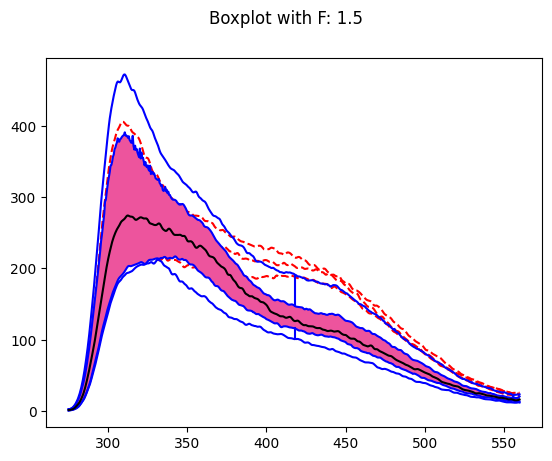

In [7]:
def functional_boxplot(data, wavelength_idx, F=1.5):
    """
    Create functional boxplot with outliers
    """
    
    X = data[:, :, wavelength_idx]
    fd = skfda.FDataGrid(data_matrix=X, grid_points=dominio, dataset_name=f'Boxplot with F: {F}')
    fdBoxplot = Boxplot(fd, factor=F)        
    fdBoxplot.plot()
    return fdBoxplot
    

fboxplot = functional_boxplot(data, wavelength_idx)
outliers = fboxplot.outliers
# Compara los outliers con data y muestrame los valores de data que son outliers
data_outliers = pd.DataFrame(data[outliers, :, wavelength_idx])
display(data_outliers)

# Análisis de la Profundidad de Variación Total y Similitud de Forma


## **1. Introducción**

Sea $X$ un proceso estocástico en $\tau$, donde $\tau$ es un intervalo en $\mathbb{R}$, con distribución $F_X$. Denotamos:

- $f$: una función.
- $f(t)$: el valor funcional en un tiempo $t$ dado.



## **2. Profundidad de Variación Total Puntual**

Para una función $f(t)$, definimos:

$$
R_f(t) = \mathbb{I}_{\{ X(t) \leq f(t) \}},
$$

donde $\mathbb{I}$ es la **función indicadora**. A partir de esta relación:

$$
p_f(t) = \mathbb{E}[R_f(t)] = \mathbb{P}\{ X(t) \leq f(t) \},
$$

lo que indica la posición de $f(t)$ con respecto a $X(t)$.

La **profundidad de variación total puntual** se define como:

$$
D_f(t) = \text{Var}[R_f(t)] = p_f(t)(1 - p_f(t)).
$$



## **3. Descomposición de la Profundidad de Variación Total**

Sea $s, t$ dos puntos en el tiempo donde $s = t - \Delta$. La profundidad de variación total puntual tiene la siguiente descomposición:

$$
D_f(t) = \text{Var}[R_f(t)] = \text{Var}[R_f(t) \mid R_f(s)] + \text{Var}\{R_f(t) \mid R_f(s)\}.
$$

Esta descomposición implica que la varianza total de $R_f(t)$ se puede dividir en:

- $\text{Var}[R_f(t) \mid R_f(s)]$: la **componente de forma**, que representa la porción de variabilidad de $R_f(t)$ explicada por $R_f(s)$.
- $\text{Var}\{R_f(t) \mid R_f(s)\}$: la **componente de magnitud**, que es independiente de $R_f(s)$.



## **4. Profundidad de Variación Total Funcional (TVD)**

La **profundidad de variación total funcional** (TVD, por sus siglas en inglés) para una función $f$ es:

$$
TVD(f) = \int w(t) D_f(t) \, dt,
$$

donde $w(t)$ es una **función de peso** definida sobre el dominio de $f(t)$. Si consideramos que $w(t)$ es constante, tal que:

$$
w(t) \equiv \frac{1}{|\tau|},
$$

entonces el TVD se comporta de manera similar a la **profundidad de banda modificada**.


## **5. Similitud de Forma (Shape Similarity, SS)**

Para cualquier función $f$ en $\mathbb{R}$, la **similitud de forma** dada una ventana temporal $\Delta$ se define como:

$$
SS(f; \Delta) = \int v(t; \Delta) S_f(t; \Delta) \, dt,
$$

donde:
- $v(t; \Delta)$: **función de peso**, dada por:

$$
v(t; \Delta) = \frac{|f(t) - f(t - \Delta)|}{\int |f(t) - f(t - \Delta)|}.
$$

- $S_f(t; \Delta)$: componente de forma, definida como:

$$
S_f(t; \Delta) = 
\begin{cases} 
\frac{\text{Var}[R_f(t) \mid R_f(t - \Delta)]}{D_f(t)}, & \text{si } D_f(t) \neq 0, \\
1, & \text{si } D_f(t) = 0.
\end{cases}
$$

### **Interpretación de la Similitud de Forma**

Valores **pequeños** de $SS(f; \Delta)$ están asociados con una **mayor desviación en la forma**. Sin embargo, para pares atípicos $(f(t - \Delta), f(t))$, si el denominador $D_f(t)$ es muy pequeño, $S_f(t; \Delta)$ podría no reflejar adecuadamente la desviación. 

Para capturar mejor esta desviación, se centra el par $(f(t - \Delta), f(t))$ mediante un **desplazamiento** $\delta_t$, donde:

$$
\delta_t = f(t) - \text{mediana}\{X(t)\}.
$$

El par ajustado es:

$$
(f(t - \Delta), f(t)) - \delta_t.
$$


## **6. Similitud de Forma Modificada (Modified Shape Similarity, MSS)**

La **similitud de forma modificada** (MSS) para una función $f$, dada una ventana temporal fija $\Delta$, se define como:

$$
MSS(f; \Delta) = \int v(t; \Delta) S_f(t; \Delta) \, dt,
$$

donde $S_f(t; \Delta)$ es:

$$
S_f(t; \Delta) = \frac{\text{Var}[R_f(t) \mid R_f(t - \Delta)]}{D_f(t)}.
$$

Además, se define $f(s; \Delta)$ como:

$$
f(s; \Delta) = 
\begin{cases} 
f(s) - f(s + \Delta) + \text{mediana}\{X(s + \Delta)\}, & \text{si } s \in \mathbb{R}.
\end{cases}
$$


---

# **Outlier Detection Procedure**

The process for detecting outliers among a set of $n$ sample curves involves the following steps:

1. **Compute Metrics**  
   - Estimate the **total variation depth** and **modified shape similarity** for each curve as before

2. **Identify Shape Outliers**  
   - Create a classical boxplot for the $n$ values of the modified shape similarity.  
   - Detect outliers using the $F \times IQR$ empirical rule, where $F$ is a user-adjustable factor.   
   - Curves with modified shape similarity values below the lower fence are classified as **shape outliers**.

3. **Identify Magnitude Outliers**  
   - Remove shape outliers and construct a **functional boxplot** using the total variation depth.  
   - Detect magnitude outliers by identifying curves outside the **50% central region** (based on the original observations) expanded by a factor of 1.5. This factor can be adjusted using bootstrap methods .  


In [8]:
import rpy2

In [9]:
%load_ext rpy2.ipython

In [10]:
X = data[:, :, wavelength_idx]

%R -i X

Además: Aviso:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [26]:
%%R
library("fdaoutlier")
# Just show me the first 5 rows in R
class_outliners <- tvdmss(X)

In [27]:
%R -o class_outliners

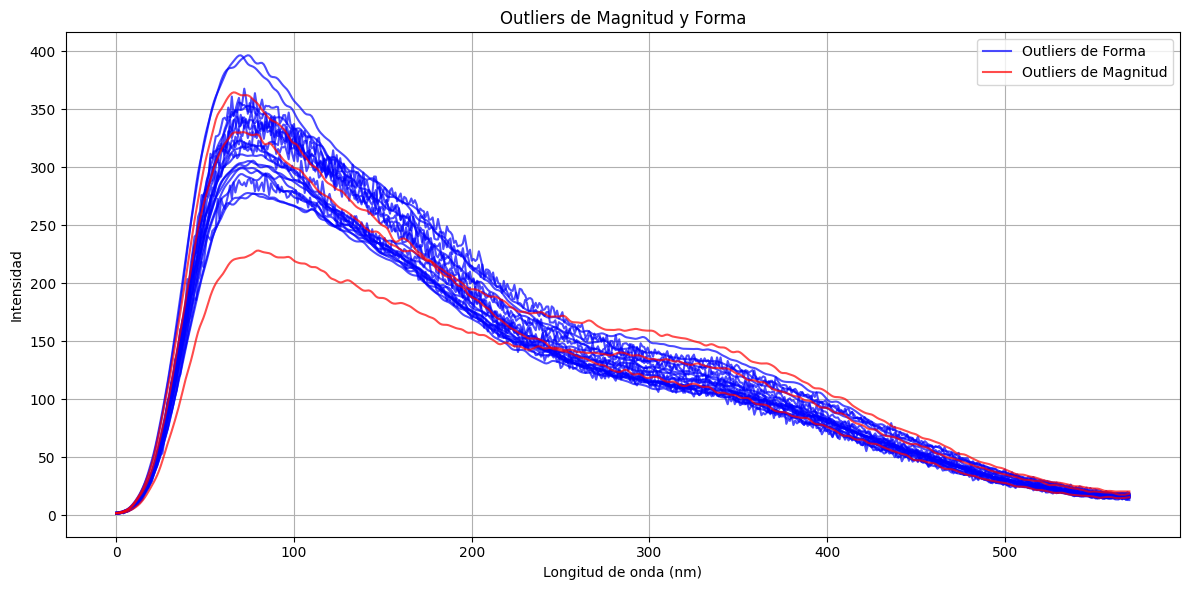

Outliers de magnitud: 3
Outliers de forma: 22


In [31]:
def plot_kind_class_outliners(outliers, X):
    """
    Plot outliers and non-outliers with different colors and labels
    """
    # Convierte los índices de outliers a un conjunto para una búsqueda eficiente
    magnitude_outliers_set = set(outliers['magnitude_outliers'])
    shape_outliers_set = set(outliers['shape_outliers'])
    
    # Crear máscaras para diferentes tipos de outliers
    magnitude_outliers_mask = np.array([i in magnitude_outliers_set for i in range(len(X))])
    shape_outliers_mask = np.array([i in shape_outliers_set for i in range(len(X))])
    
    # Encuentra los magnitude outliers en X
    magnitude_outliers = X[magnitude_outliers_mask, :]
    
    # Encuentra los shape outliers en X
    shape_outliers = X[shape_outliers_mask, :]
    
    # Encuentra las curvas que no son outliers
    non_outliers_mask = ~(magnitude_outliers_mask | shape_outliers_mask)
    non_outliers = X[non_outliers_mask, :]
    
    # Grafica los tipos de curvas
    plt.figure(figsize=(12, 6))
    
        
    for i in range(shape_outliers.shape[0]):
        plt.plot(shape_outliers[i], color='blue', alpha=0.7, label=('' if i==0 else '_') + 'Outliers de Forma')
    
    for i in range(magnitude_outliers.shape[0]):
        plt.plot(magnitude_outliers[i], color='red', alpha=0.7, label=('' if i==0 else '_') + 'Outliers de Magnitud')
        
    plt.title('Outliers de Magnitud y Forma')
    plt.xlabel('Longitud de onda (nm)')
    plt.ylabel('Intensidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Llamada a la función
plot_kind_class_outliners(class_outliners, X)

# imprime cuantos outliers de magnitud y forma hay
print(f"Outliers de magnitud: {len(class_outliners['magnitude_outliers'])}")
print(f"Outliers de forma: {len(class_outliners['shape_outliers'])}")

# Mediana funcional multivariada

# Revision permisos de R  

In [30]:
%%R

install.packages("devtools")

* installing *source* package ‘Rcpp’ ...
** package ‘Rcpp’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include/      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c api.cpp -o api.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include/      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c attributes.cpp -o attributes.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include/      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c barrier.cpp -o barrier.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include/      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time 

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-Rcpp/00new/Rcpp/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Rcpp)
* installing *source* package ‘utf8’ ...
** package ‘utf8’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG      -Iutf8lite/src -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c as_utf8.c -o as_utf8.o
gcc -I"/usr/share/R/include" -DNDEBUG      -Iutf8lite/src -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c bytes.c -o bytes.o
gcc -I"/usr/share/R/include" -DNDEBUG      -Iutf8lite/src -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c context.c -o context.o
gcc -I"/usr/share/R/include" -DNDEBUG      -Iutf8lite/src -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG 

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-utf8/00new/utf8/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (utf8)
* installing *source* package ‘sys’ ...
** package ‘sys’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c exec.c -o exec.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o sys.so exec.o init.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-sys/00new/sys/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (sys)
* installing *source* package ‘zip’ ...
** package ‘zip’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  miniz.c zip.c unixutils.c tools/cmdzip.c -o tools/cmdzip
gcc -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  miniz.c zip.c unixutils.c tools/cmdunzip.c -o tools/cmdunzip
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c miniz.c -o miniz.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -fpic  -g -O2 -ffile-

installing via 'install.libs.R' to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-zip/00new/zip
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (zip)
* installing *source* package ‘gitcreds’ ...
** package ‘gitcreds’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a reco

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -Ilib/     -DR_NO_REMAP -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c fastmap.cpp -o fastmap.o
gcc -I"/usr/share/R/include" -DNDEBUG -Ilib/      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
g++ -std=gnu++17 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o fastmap.so fastmap.o init.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-fastmap/00new/fastmap/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fastmap)
* installing *source* package ‘mime’ ...
** package ‘mime’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c rawmatch.c -o rawmatch.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o mime.so init.o rawmatch.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-mime/00new/mime/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (mime)
* installing *source* package ‘xtable’ ...
** package ‘xtable’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of tem

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c Reader.cpp -o Reader.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c Tokenizer.cpp -o Tokenizer.o
gcc -I"/usr/share/R/include" -DNDEBUG -I../inst/include      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c sourcetools-init.c -o sourcetools-init.o
g++ -std=gnu++17 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o sourcetools.so Reader.o Tokenizer.o sourcetools-init.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-sourcetools/00new/sourcetools/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (sourcetools)
* installing *source* package ‘base64enc’ ...
** package ‘base64enc’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c base64.c -o base64.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c uriencode.c -o uriencode.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c utf8.c -o utf8.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o base64enc.so base64.o uriencode.o utf8.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-base64enc/00new/base64enc/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (base64enc)
* installing *source* package ‘fansi’ ...
** package ‘fansi’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c assumptions.c -o assumptions.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c carry.c -o carry.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c has.c -o has.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-fansi/00new/fansi/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fansi)
* installing *source* package ‘xfun’ ...
** package ‘xfun’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c base64.c -o base64.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o xfun.so base64.o init.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-xfun/00new/xfun/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (xfun)
* installing *source* package ‘pkgconfig’ ...
** package ‘pkgconfig’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of tempo

Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/usr/include/x86_64-linux-gnu
Using PKG_LIBS=-lcurl
Found recent recent version of libcurl


** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


rm -f curl.so callbacks.o curl.o download.o escape.o fetch.o findport.o form.o getdate.o handle.o ieproxy.o init.o interrupt.o multi.o nslookup.o options.o reflist.o split.o ssl.o typechecking.o urlparser.o utils.o version.o winidn.o writer.o
gcc -I"/usr/share/R/include" -DNDEBUG -I/usr/include/x86_64-linux-gnu -DSTRICT_R_HEADERS -DR_NO_REMAP     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c callbacks.c -o callbacks.o
gcc -I"/usr/share/R/include" -DNDEBUG -I/usr/include/x86_64-linux-gnu -DSTRICT_R_HEADERS -DR_NO_REMAP     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c curl.c -o curl.o
gcc -I"/usr/share/R/include" -DNDEBUG -I/usr/include/x86_64-linux-gnu -DSTRICT_R_HEADERS -DR_NO_REMAP     -fvisibility=hidden -fpic  -g -

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-curl/00new/curl/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (curl)
* installing *source* package ‘glue’ ...
** package ‘glue’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c glue.c -o glue.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c trim.c -o trim.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o glue.so glue.o init.o trim.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-glue/00new/glue/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (glue)
* installing *source* package ‘jsonlite’ ...
** package ‘jsonlite’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG -Iyajl/api     -fvisibility=hidden  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c base64.c -o base64.o
gcc -I"/usr/share/R/include" -DNDEBUG -Iyajl/api     -fvisibility=hidden  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c collapse_array.c -o collapse_array.o
gcc -I"/usr/share/R/include" -DNDEBUG -Iyajl/api     -fvisibility=hidden  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c collapse_object.c -o collapse_object.o
gcc -I"/usr/share/R/include" -DNDEBUG -Iyajl/api     -fvisibility=hidden  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-secu

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-jsonlite/00new/jsonlite/libs
** R
** inst
** byte-compile and prepare package for lazy loading


in method for ‘asJSON’ with signature ‘"AsIs"’: no definition for class “AsIs”
in method for ‘asJSON’ with signature ‘"ITime"’: no definition for class “ITime”
in method for ‘asJSON’ with signature ‘"hms"’: no definition for class “hms”
in method for ‘asJSON’ with signature ‘"json"’: no definition for class “json”
in method for ‘asJSON’ with signature ‘"integer64"’: no definition for class “integer64”
in method for ‘asJSON’ with signature ‘"pairlist"’: no definition for class “pairlist”
in method for ‘asJSON’ with signature ‘"blob"’: no definition for class “blob”
in method for ‘asJSON’ with signature ‘"scalar"’: no definition for class “scalar”
in method for ‘asJSON’ with signature ‘"sf"’: no definition for class “sf”
in method for ‘asJSON’ with signature ‘"sfc"’: no definition for class “sfc”
in method for ‘asJSON’ with signature ‘"vctrs_vctr"’: no definition for class “vctrs_vctr”


** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (jsonlite)
* installing *source* package ‘rappdirs’ ...
** package ‘rappdirs’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c win-path.c -o win-path.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o rappdirs.so init.o win-path.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-rappdirs/00new/rappdirs/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (rappdirs)
* installing *source* package ‘rprojroot’ ...
** package ‘rprojroot’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package

gcc -I"/usr/share/R/include" -DNDEBUG -I. -DNDEBUG      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c api.c -o api.o
gcc -I"/usr/share/R/include" -DNDEBUG -I. -DNDEBUG      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c dumper.c -o dumper.o
gcc -I"/usr/share/R/include" -DNDEBUG -I. -DNDEBUG      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c emitter.c -o emitter.o
gcc -I"/usr/share/R/include" -DNDEBUG -I. -DNDEBUG      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c implicit.c -o implicit.o
gcc -I"/usr/share/R/include" -DNDEBUG -I. -D

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-yaml/00new/yaml/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (yaml)
* installing *source* package ‘R6’ ...
** package ‘R6’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* D

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c SpookyV2.cpp -o SpookyV2.o
gcc -I"/usr/share/R/include" -DNDEBUG -I.      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c aes.c -o aes.o
gcc -I"/usr/share/R/include" -DNDEBUG -I.      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c blake3.c -o blake3.o
gcc -I"/usr/share/R/include" -DNDEBUG -I.      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c blake3_dispatch.c -o blake3_dispatch.o
gcc -I"/usr/share/R/include" -DNDEBUG -I.      -

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-digest/00new/digest/libs
** R
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (digest)
* installing *source* package ‘prettyunits’ ...
** package ‘prettyunits’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a recor

rm -f cmark/cmark.o cmark/node.o cmark/iterator.o cmark/blocks.o cmark/inlines.o cmark/scanners.o cmark/utf8.o cmark/buffer.o cmark/references.o cmark/render.o cmark/man.o cmark/xml.o cmark/html.o cmark/commonmark.o cmark/latex.o cmark/houdini_href_e.o cmark/houdini_html_e.o cmark/houdini_html_u.o cmark/cmark_ctype.o cmark/arena.o cmark/linked_list.o cmark/plugin.o cmark/registry.o cmark/syntax_extension.o cmark/plaintext.o cmark/footnotes.o cmark/map.o extensions/autolink.o extensions/core-extensions.o extensions/ext_scanners.o extensions/strikethrough.o extensions/table.o extensions/tagfilter.o extensions/tasklist.o extensions.o init.o wrapper.o commonmark.so cmark/libstatcmark.a
gcc -I"/usr/share/R/include" -DNDEBUG -Icmark -I. -DCMARK_GFM_STATIC_DEFINE -DCMARK_GFM_EXTENSIONS_STATIC_DEFINE -DR_NO_REMAP -DSTRICT_R_HEADERS     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-commonmark/00new/commonmark/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (commonmark)
* installing *source* package ‘stringi’ ...
** package ‘stringi’ successfully unpacked and MD5 sums checked
** using staged installation


checking for R_HOME... /usr/lib/R
checking for R... /usr/lib/R/bin/R
checking for endianness... little
checking for cat... /usr/bin/cat
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C++... yes
checking whether g++ -std=gnu++17 accepts -g... yes
checking for g++ -std=gnu++17 option to enable C++11 features... none needed
checking whether the C++ compiler supports the 'long long' type... yes
checking whether the compiler implements namespaces... yes
checking whether the compiler supports the Standard Template Library... yes
checking whether std::map is available... yes
checking for pkg-config... /usr/bin/pkg-config
checking with 'pkg-config' for the system ICU4C (icu-i18n icu-uc)... 70.1
checking for ICU4C >= 61... yes
checking for additional CPPFLAGS, LDFLAGS, 

** libs
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c stri_collator.cpp -o stri_collator.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c stri_common.cpp -o stri_common.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c stri_compare.cpp -o stri_compare.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic 

In file included from stri_ICU_settings.cpp:37:
uconfig_local.h:42: warning: "UCONFIG_USE_WINDOWS_LCID_MAPPING_API" redefined
   42 | #define UCONFIG_USE_WINDOWS_LCID_MAPPING_API 0
      | 
In file included from /usr/include/unicode/platform.h:24,
                 from /usr/include/unicode/ptypes.h:52,
                 from stri_external.h:52,
                 from stri_stringi.h:36,
                 from stri_ICU_settings.cpp:33:
/usr/include/unicode/uconfig.h:381: note: this is the location of the previous definition
  381 | #   define UCONFIG_USE_WINDOWS_LCID_MAPPING_API 1
      | 


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c stri_join.cpp -o stri_join.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c stri_length.cpp -o stri_length.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c stri_pad.cpp -o stri_pad.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -ffile-p

In file included from stri_stringi.cpp:39:
uconfig_local.h:42: warning: "UCONFIG_USE_WINDOWS_LCID_MAPPING_API" redefined
   42 | #define UCONFIG_USE_WINDOWS_LCID_MAPPING_API 0
      | 
In file included from /usr/include/unicode/platform.h:24,
                 from /usr/include/unicode/ptypes.h:52,
                 from stri_external.h:52,
                 from stri_stringi.h:36,
                 from stri_stringi.cpp:33:
/usr/include/unicode/uconfig.h:381: note: this is the location of the previous definition
  381 | #   define UCONFIG_USE_WINDOWS_LCID_MAPPING_API 1
      | 


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c stri_sub.cpp -o stri_sub.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c stri_test.cpp -o stri_test.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c stri_time_zone.cpp -o stri_time_zone.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I.   -UDEBUG -DNDEBUG -DU_HAVE_ELF_H      -fpic -fpic  -g -O2 -f

installing via 'install.libs.R' to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-stringi/00new/stringi
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (stringi)
* installing *source* package ‘cpp11’ ...
** package ‘cpp11’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps 

gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c brio.c -o brio.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c file_line_endings.c -o file_line_endings.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c read_file.c -o read_file.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-brio/00new/brio/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (brio)
* installing *source* package ‘evaluate’ ...
** package ‘evaluate’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (evaluate)
*

gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c pipe.c -o pipe.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c utils.c -o utils.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o magrittr.so pipe.o utils.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-magrittr/00new/magrittr/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (magrittr)
* installing *source* package ‘praise’ ...
** package ‘praise’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed packa

gcc -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -Wall px.c -o px
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c api-common.c -o api-common.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c common.c -o common.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile

installing via 'install.libs.R' to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-ps/00new/ps
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ps)
* installing *source* package ‘cli’ ...
** package ‘cli’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -I../inst/include -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c ansi.c -o ansi.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -I../inst/include -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c cleancall.c -o cleancall.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -I../inst/include -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c diff.c -o diff.o
gcc -I"/usr/share/R/include" -DNDEBUG      -fvisibility=hidden -I../inst/include -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wd

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-cli/00new/cli/libs
** R
** exec
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (cli)
* installing *source* package ‘fs’ ...
** package ‘fs’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I./libuv-1.44.2/include -I. -pthread      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c dir.cc -o dir.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I./libuv-1.44.2/include -I. -pthread      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c error.cc -o error.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I./libuv-1.44.2/include -I. -pthread      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c file.cc -o file.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I./libuv-1.44.2/include -I. -pthread      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-prote

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-fs/00new/fs/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fs)
* installing *source* package ‘remotes’ ...
** package ‘remotes’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if install

gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang/     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c capture.c -o capture.o
gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang/     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c internal.c -o internal.o
gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang/     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c rlang.c -o rlang.o
gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang/     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-rlang/00new/rlang/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (rlang)
* installing *source* package ‘withr’ ...
** package ‘withr’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if instal

gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c askpass.c -o askpass.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o askpass.so askpass.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-askpass/00new/askpass/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (askpass)
* installing *source* package ‘later’ ...
** package ‘later’ successfully unpacked and MD5 sums checked
** using staged installation


Running configure script
-latomic linker flag not needed.
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -pthread -DSTRICT_R_HEADERS -DRCPP_NO_MODULES  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c RcppExports.cpp -o RcppExports.o


** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -pthread -DSTRICT_R_HEADERS -DRCPP_NO_MODULES  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c callback_registry.cpp -o callback_registry.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -pthread -DSTRICT_R_HEADERS -DRCPP_NO_MODULES  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c debug.cpp -o debug.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -pthread -DSTRICT_R_HEADERS -DRCPP_NO_MODULES  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-later/00new/later/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (later)
* installing *source* package ‘tinytex’ ...
** package ‘tinytex’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of tempor

gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c diff.c -o diff.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c diffobj.c -o diffobj.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o diffobj.so diff.o diffobj.o init.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-diffobj/00new/diffobj/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (diffobj)
* installing *source* package ‘cachem’ ...
** package ‘cachem’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c cache.c -o cache.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o cachem.so cache.o init.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-cachem/00new/cachem/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (cachem)
* installing *source* package ‘htmltools’ ...
** package ‘htmltools’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c template.c -o template.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o htmltools.so init.o template.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-htmltools/00new/htmltools/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (htmltools)
* installing *source* package ‘processx’ ...
** package ‘processx’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -Wall tools/px.c -o tools/px
gcc -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -I../inst/include -Wall tools/sock.c -o tools/sock
gcc -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro supervisor/supervisor.c \
      supervisor/utils.c -o supervisor/supervisor
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wfor

installing via 'install.libs.R' to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-processx/00new/processx
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (processx)
* installing *source* package ‘xml2’ ...
** package ‘xml2’ successfully unpacked and MD5 sums checked
** using staged installation


Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/usr/include/libxml2
Using PKG_LIBS=-lxml2


** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include -I/usr/include/libxml2 -DUCHAR_TYPE=wchar_t -DU_SHOW_CPLUSPLUS_API=0     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c connection.cpp -o connection.o
gcc -I"/usr/share/R/include" -DNDEBUG -I../inst/include -I/usr/include/libxml2 -DUCHAR_TYPE=wchar_t -DU_SHOW_CPLUSPLUS_API=0      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include -I/usr/include/libxml2 -DUCHAR_TYPE=wchar_t -DU_SHOW_CPLUSPLUS_API=0     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c xml2_doc.c

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-xml2/00new/xml2/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (xml2)
* installing *source* package ‘desc’ ...
** package ‘desc’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a recor

gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c dots.c -o dots.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o ellipsis.so dots.o init.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-ellipsis/00new/ellipsis/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ellipsis)
* installing *source* package ‘lifecycle’ ...
** package ‘lifecycle’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/later/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c RcppExports.cpp -o RcppExports.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/later/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c promise_task.cpp -o promise_task.o
g++ -std=gnu++17 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o promises.so RcppExports.o promise_task.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-promises/00new/promises/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (promises)
* installing *source* package ‘jquerylib’ ...
** package ‘jquerylib’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed

gcc -I"/usr/share/R/include" -DNDEBUG -I./libsass/include      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c compile.c -o compile.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I./libsass/include      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c init.cpp -o init.o
MAKEFLAGS= CC="gcc" CFLAGS="-g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 " CXX="g++ -std=gnu++17" AR="ar" LDFLAGS="-Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro" make -C libsass
make[1]: se entra en el directorio '/tmp/RtmpOaQJeG/R.INSTALL7da7353f35b2/sass/src/libsass'
gcc -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-str

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-sass/00new/sass/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (sass)
* installing *source* package ‘systemfonts’ ...
** package ‘systemfonts’ successfully unpacked and MD5 sums checked
** using staged installation


Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/usr/include/uuid -I/usr/include/freetype2 -I/usr/include/libpng16
Using PKG_LIBS=-lfontconfig -lfreetype


** libs
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


rm -f systemfonts.so caches.o cpp11.o dev_metrics.o font_matching.o font_registry.o ft_cache.o string_shape.o font_metrics.o font_fallback.o string_metrics.o emoji.o cache_store.o init.o unix/FontManagerLinux.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I/usr/include/uuid -I/usr/include/freetype2 -I/usr/include/libpng16 -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/cpp11/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c caches.cpp -o caches.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I/usr/include/uuid -I/usr/include/freetype2 -I/usr/include/libpng16 -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/cpp11/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c cpp11.cpp -o cpp11.o
g++ -std=gnu++17 -I"/usr/share/R/include"

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-systemfonts/00new/systemfonts/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (systemfonts)
* installing *source* package ‘callr’ ...
** package ‘callr’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
**

Found pkg-config cflags and libs!
Using PKG_CFLAGS=
Using PKG_LIBS=-l:libssl.so.3 -l:libcrypto.so.3
rm -f aes.o base64.o bignum.o cert.o compatibility.o diffie.o envelope.o error.o hash.o info.o keygen.o keys.o onload.o openssh.o password.o pbkdf.o pem.o pkcs12.o pkcs7.o rand.o rsa.o signing.o ssl.o stream.o write.o x25519.o openssl.so bcrypt/libstatbcrypt.a bcrypt/bcrypt_pbkdf.o bcrypt/blowfish.o
gcc -I"/usr/share/R/include" -DNDEBUG -DOPENSSL_SUPPRESS_DEPRECATED      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c aes.c -o aes.o


** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG -DOPENSSL_SUPPRESS_DEPRECATED      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c base64.c -o base64.o
gcc -I"/usr/share/R/include" -DNDEBUG -DOPENSSL_SUPPRESS_DEPRECATED      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c bignum.c -o bignum.o
gcc -I"/usr/share/R/include" -DNDEBUG -DOPENSSL_SUPPRESS_DEPRECATED      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c cert.c -o cert.o
gcc -I"/usr/share/R/include" -DNDEBUG -DOPENSSL_SUPPRESS_DEPRECATED      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c c

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-openssl/00new/openssl/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (openssl)
* installing *source* package ‘vctrs’ ...
** package ‘vctrs’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c altrep-lazy-character.c -o altrep-lazy-character.o
gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c altrep-rle.c -o altrep-rle.o
gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c altrep.c -o altrep.o
gcc -I"/usr/share/R/include" -DNDEBUG -I./rlang     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-vctrs/00new/vctrs/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (vctrs)
* installing *source* package ‘xopen’ ...
** package ‘xopen’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a 

** Using libuv found by pkg-config in /usr
** PKG_CFLAGS=
** PKG_LIBS=-luv -lpthread -ldl -lrt
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -pthread -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/later/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'    -fvisibility=hidden -DSTRICT_R_HEADERS -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c RcppExports.cpp -o RcppExports.o


** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -pthread -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/later/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'    -fvisibility=hidden -DSTRICT_R_HEADERS -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c callback.cpp -o callback.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -pthread -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/later/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'    -fvisibility=hidden -DSTRICT_R_HEADERS -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c callbackqueue.cpp -o callbackqueue.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -pthread -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/later/include' -I'/home/plealm/R/x86_6

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-httpuv/00new/httpuv/libs
** R
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (httpuv)
* installing *source* package ‘textshaping’ ...
** package ‘textshaping’ successfully unpacked and MD5 sums checked
** using staged installation


Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/usr/include/harfbuzz -I/usr/include/glib-2.0 -I/usr/lib/x86_64-linux-gnu/glib-2.0/include -I/usr/include/freetype2 -I/usr/include/libpng16 -I/usr/include/fribidi
Using PKG_LIBS=-lharfbuzz -lfreetype -lfribidi


** libs
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


rm -f textshaping.so cpp11.o face_feature.o hb_shaper.o init.o string_bidi.o string_metrics.o string_shape.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -DNDEBUG -I/usr/include/harfbuzz -I/usr/include/glib-2.0 -I/usr/lib/x86_64-linux-gnu/glib-2.0/include -I/usr/include/freetype2 -I/usr/include/libpng16 -I/usr/include/fribidi -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/cpp11/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/systemfonts/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c cpp11.cpp -o cpp11.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -DNDEBUG -I/usr/include/harfbuzz -I/usr/include/glib-2.0 -I/usr/lib/x86_64-linux-gnu/glib-2.0/include -I/usr/include/freetype2 -I/usr/include/libpng16 -I/usr/include/fribidi -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/cpp11/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/sy

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-textshaping/00new/textshaping/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (textshaping)
* installing *source* package ‘pillar’ ...
** package ‘pillar’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loa

gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/cli/include'    -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c backports.c -o backports.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/cli/include'    -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c cleancall.c -o cleancall.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/cli/include'    -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c coerce.c -o coerce.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-purrr/00new/purrr/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (purrr)
* installing *source* package ‘bslib’ ...
** package ‘bslib’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if instal

Found OpenSSL3
Using static libgit2 for Linux x86_64
Using PKG_CFLAGS=-DSTATIC_LIBGIT2 -I/tmp/RtmpxNiZqF/R.INSTALL93179c55be1/gert/libgit2-1.4.2-x86_64_linux/include
Using PKG_LIBS=-L/tmp/RtmpxNiZqF/R.INSTALL93179c55be1/gert/libgit2-1.4.2-x86_64_linux/lib -lstatgit2 -lrt -lpthread -lstatssh2 -lstatssl -lstatcrypto -ldl
Configuration OK!


** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


rm -f gert.so branch.o clone.o commit.o config.o conflicts.o files.o ignore.o init.o merge.o rebase.o stash.o submodules.o tag.o utils.o version.o
gcc -I"/usr/share/R/include" -DNDEBUG -DSTATIC_LIBGIT2 -I/tmp/RtmpxNiZqF/R.INSTALL93179c55be1/gert/libgit2-1.4.2-x86_64_linux/include -DR_NO_REMAP -DSTRICT_R_HEADERS     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c branch.c -o branch.o
gcc -I"/usr/share/R/include" -DNDEBUG -DSTATIC_LIBGIT2 -I/tmp/RtmpxNiZqF/R.INSTALL93179c55be1/gert/libgit2-1.4.2-x86_64_linux/include -DR_NO_REMAP -DSTRICT_R_HEADERS     -fvisibility=hidden -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c clone.c -o clone.o
gcc -I"/usr/share/R/include" -DNDEBUG -DSTATIC_LIBGIT2 -I/tmp/RtmpxNiZqF/R.INSTALL93179c55be1/gert/libgit2-1.

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-gert/00new/gert/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (gert)
* installing *source* package ‘gh’ ...
** package ‘gh’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** te

Found pkg-config cflags and libs!
Using PKG_CFLAGS=-I/usr/include/freetype2 -I/usr/include/libpng16 -I/usr/include/x86_64-linux-gnu
Using PKG_LIBS=-lfreetype -lpng16 -lz -ltiff -ljpeg
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I./agg/include -I/usr/include/freetype2 -I/usr/include/libpng16 -I/usr/include/x86_64-linux-gnu -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/systemfonts/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/textshaping/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c capture_dev.cpp -o capture_dev.o


** libs
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I./agg/include -I/usr/include/freetype2 -I/usr/include/libpng16 -I/usr/include/x86_64-linux-gnu -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/systemfonts/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/textshaping/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c init.cpp -o init.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I./agg/include -I/usr/include/freetype2 -I/usr/include/libpng16 -I/usr/include/x86_64-linux-gnu -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/systemfonts/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/textshaping/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c jpeg_dev.cpp -o jpeg_dev.o
g++ -std=gnu++17 -I"/usr/share/R/include

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-ragg/00new/ragg/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ragg)
* installing *source* package ‘rmarkdown’ ...
** package ‘rmarkdown’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed

gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c attributes.c -o attributes.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c coerce.c -o coerce.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c matrixToDataFrame.c -o matrixToDataFrame.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-tibble/00new/tibble/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (tibble)
* installing *source* package ‘pkgload’ ...
** package ‘pkgload’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package k

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/cpp11/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c cpp11.cpp -o cpp11.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/cpp11/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c escapeExamples.cpp -o escapeExamples.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/cpp11/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c isComplete.cpp -o isComplete.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/h

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-roxygen2/00new/roxygen2/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (roxygen2)
* installing *source* package ‘testthat’ ...
** package ‘testthat’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG -I../inst/include -DCOMPILING_TESTTHAT      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -I"/usr/share/R/include" -DNDEBUG -I../inst/include -DCOMPILING_TESTTHAT      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c reassign.c -o reassign.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include -DCOMPILING_TESTTHAT      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c test-catch.cpp -o test-catch.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include -DCOMPILING_TESTTHAT      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-testthat/00new/testthat/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (testthat)
* installing *source* package ‘profvis’ ...
** package ‘profvis’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c pause.c -o pause.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c profvis-init.c -o profvis-init.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o profvis.so pause.o profvis-init.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-profvis/00new/profvis/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (profvis)
* installing *source* package ‘devtools’ ...
** package ‘devtools’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** t

Installing package into ‘/home/plealm/R/x86_64-pc-linux-gnu-library/4.x’
(as ‘lib’ is unspecified)
also installing the dependencies ‘Rcpp’, ‘utf8’, ‘askpass’, ‘credentials’, ‘sys’, ‘zip’, ‘gitcreds’, ‘ini’, ‘fastmap’, ‘httpuv’, ‘mime’, ‘xtable’, ‘sourcetools’, ‘later’, ‘promises’, ‘base64enc’, ‘jquerylib’, ‘sass’, ‘fansi’, ‘systemfonts’, ‘textshaping’, ‘tinytex’, ‘xfun’, ‘pillar’, ‘pkgconfig’, ‘highr’, ‘diffobj’, ‘clipr’, ‘crayon’, ‘curl’, ‘gert’, ‘gh’, ‘glue’, ‘jsonlite’, ‘purrr’, ‘rappdirs’, ‘rprojroot’, ‘rstudioapi’, ‘whisker’, ‘yaml’, ‘R6’, ‘cachem’, ‘shiny’, ‘htmltools’, ‘callr’, ‘processx’, ‘bslib’, ‘digest’, ‘downlit’, ‘fontawesome’, ‘httr2’, ‘openssl’, ‘ragg’, ‘rmarkdown’, ‘tibble’, ‘xml2’, ‘htmlwidgets’, ‘vctrs’, ‘prettyunits’, ‘xopen’, ‘brew’, ‘commonmark’, ‘knitr’, ‘stringi’, ‘stringr’, ‘cpp11’, ‘brio’, ‘evaluate’, ‘magrittr’, ‘praise’, ‘ps’, ‘waldo’, ‘usethis’, ‘cli’, ‘desc’, ‘ellipsis’, ‘fs’, ‘lifecycle’, ‘memoise’, ‘miniUI’, ‘pkgbuild’, ‘pkgdown’, ‘pkgload’, ‘profvis’, ‘r

In [32]:
%%R
devtools::install_github("PSegaert/mrfDepth")

* installing *source* package ‘lpSolve’ ...
** package ‘lpSolve’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG -I . -DINTEGERTIME -DPARSER_LP -DBUILDING_FOR_R -DYY_NEVER_INTERACTIVE -DUSRDLL -DCLOCKTIME -DRoleIsExternalInvEngine -DINVERSE_ACTIVE=INVERSE_LUSOL -DINLINE=static -DParanoia      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c colamd.c -o colamd.o
gcc -I"/usr/share/R/include" -DNDEBUG -I . -DINTEGERTIME -DPARSER_LP -DBUILDING_FOR_R -DYY_NEVER_INTERACTIVE -DUSRDLL -DCLOCKTIME -DRoleIsExternalInvEngine -DINVERSE_ACTIVE=INVERSE_LUSOL -DINLINE=static -DParanoia      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c commonlib.c -o commonlib.o
gcc -I"/usr/share/R/include" -DNDEBUG -I . -DINTEGERTIME -DPARSER_LP -DBUILDING_FOR_R -DYY_NEVER_INTERACTIVE -DUSRDLL -DCLOCKTIME -DRoleIsExternalInvEngine -DINVERSE_ACTIVE=INVERSE_LUSOL -DI

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-lpSolve/00new/lpSolve/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (lpSolve)
* installing *source* package ‘abind’ ...
** package ‘abind’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (abind)
*

gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c colorspace.c -o colorspace.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o colorspace.so colorspace.o init.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-colorspace/00new/colorspace/libs
** R
** data
*** moving datasets to lazyload DB
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (colorspace)
* installing *source* package ‘viridisLite’ ...
** package ‘viridisLite’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed pack

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c ColorSpace.cpp -o ColorSpace.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c Comparison.cpp -o Comparison.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c Conversion.cpp -o Conversion.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c encode.cpp -o encode.o
g++ 

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-farver/00new/farver/libs
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (farver)
* installing *source* package ‘plyr’ ...
** package ‘plyr’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c RcppExports.cpp -o RcppExports.o
gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c loop_apply.c -o loop_apply.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c split-numeric.cpp -o split-numeric.o
g++ -std=gnu++17 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-plyr/00new/plyr/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (plyr)
* installing *source* package ‘RcppProgress’ ...
** package ‘RcppProgress’ successfully unpacked and MD5 sums checked
** using staged installation
** inst
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (Rc

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c clip-lines.cpp -o clip-lines.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c init.cpp -o init.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c isoband.cpp -o isoband.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c polygon.cpp -o polygon.o
g++ -std=gnu++11 -I"

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-isoband/00new/isoband/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (isoband)
* installing *source* package ‘gtable’ ...
** package ‘gtable’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from fin

checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether the compiler supports GNU C++... yes
checking whether g++ -std=gnu++17 accepts -g... yes
checking for g++ -std=gnu++17 option to enable C++11 features... none needed
checking how to run the C++ preprocessor... g++ -std=gnu++17 -E
checking whether the compiler supports GNU C++... (cached) yes
checking whether g++ -std=gnu++17 accepts -g... (cached) yes
checking for g++ -std=gnu++17 option to enable C++11 features... (cached) none needed
checking whether we have a suitable tempdir... /tmp
checking whether R CMD SHLIB can already compile programs using OpenMP... yes
checking LAPACK_LIBS... system LAPACK found
configure: creating ./config.status
config.status: creating inst/include/RcppArmadillo/config/RcppArmadilloConfigGenerated.h
config.stat

** libs
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'    -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c RcppExports.cpp -o RcppExports.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -I../inst/include -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'    -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c fastLm.cpp -o fastLm.o
g++ -std=gnu++17 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o RcppArmadillo.so RcppArmadillo.o RcppExports.o fastLm.o -fopenmp -llapack -lblas -lgfortran -lm -lquadmath -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-RcppArmadillo/00new/RcppArmadillo/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (RcppArmadillo)
* installing *source* package ‘RcppEigen’ ...
** package ‘RcppEigen’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'    -I../inst/include -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c RcppEigen.cpp -o RcppEigen.o


In file included from ../inst/include/Eigen/Core:205,
                 from ../inst/include/Eigen/Dense:1,
                 from ../inst/include/RcppEigenForward.h:28,
                 from ../inst/include/RcppEigen.h:25,
                 from RcppEigen.cpp:22:
../inst/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
../inst/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
../inst/include/Eigen/src/Core/arch/SSE/PacketMath.h:49:39: warning: ignoring attributes on template argument ‘__m128’ [-Wignored-attributes]
   49 | template<> struct is_arithmetic<__m128>  { enum { value = true }; };
      |         

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'    -I../inst/include -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c RcppExports.cpp -o RcppExports.o


In file included from ../inst/include/Eigen/Core:205,
                 from ../inst/include/Eigen/Dense:1,
                 from ../inst/include/RcppEigenForward.h:28,
                 from ../inst/include/RcppEigen.h:25,
                 from RcppExports.cpp:4:
../inst/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
../inst/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
../inst/include/Eigen/src/Core/arch/SSE/PacketMath.h:49:39: warning: ignoring attributes on template argument ‘__m128’ [-Wignored-attributes]
   49 | template<> struct is_arithmetic<__m128>  { enum { value = true }; };
      |        

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'    -I../inst/include -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c fastLm.cpp -o fastLm.o


In file included from ../inst/include/Eigen/Core:205,
                 from ../inst/include/Eigen/Dense:1,
                 from ../inst/include/RcppEigenForward.h:28,
                 from ../inst/include/RcppEigen.h:25,
                 from fastLm.h:25,
                 from fastLm.cpp:23:
../inst/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
../inst/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
../inst/include/Eigen/src/Core/arch/SSE/PacketMath.h:49:39: warning: ignoring attributes on template argument ‘__m128’ [-Wignored-attributes]
   49 | template<> struct is_arithmetic<__m128>  { enum { val

g++ -std=gnu++17 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o RcppEigen.so RcppEigen.o RcppExports.o fastLm.o -llapack -lblas -lgfortran -lm -lquadmath -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-RcppEigen/00new/RcppEigen/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (RcppEigen)
* installing *source* package ‘matrixStats’ ...
** package ‘matrixStats’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c 000.init.c -o 000.init.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c allocMatrix2.c -o allocMatrix2.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c anyMissing.c -o anyMissing.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c binCounts.c -o binCounts.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffi

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-matrixStats/00new/matrixStats/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (matrixStats)
* installing *source* package ‘munsell’ ...
** package ‘munsell’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if inst

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c RcppExports.cpp -o RcppExports.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c melt.cpp -o melt.o
g++ -std=gnu++17 -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o reshape2.so RcppExports.o melt.o -L/usr/lib/R/lib -lR


installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-reshape2/00new/reshape2/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (reshape2)
* installing *source* package ‘scales’ ...
** package ‘scales’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if inst

g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -DR_NO_REMAP -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppProgress/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c QuadTree.cpp -o QuadTree.o
gcc -I"/usr/share/R/include" -DNDEBUG -DR_NO_REMAP -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppProgress/include'    -include Rgeometry.h -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c Rconvhulln.c -o Rconvhulln.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG -DR_NO_REMAP -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppProgress/include'     

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-geometry/00new/geometry/libs
** R
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (geometry)
* installing *source* package ‘ggplot2’ ...
** package ‘ggplot2’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if inst

── R CMD build ─────────────────────────────────────────────────────────────────


** testing if installed package keeps a record of temporary installation path
* DONE (ggplot2)


* checking for file ‘/tmp/RtmpyvPr2A/remotes23fc6cbb598f/PSegaert-mrfDepth-a1118dd/DESCRIPTION’ ... OK
* preparing ‘mrfDepth’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘mrfDepth_1.0.10.tar.gz’



* installing *source* package ‘mrfDepth’ ...
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using Fortran compiler: ‘GNU Fortran (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using C++11


g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I../inst/include  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppArmadillo/include'    -DEIGEN_DONT_PARALLELIZE -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c AdjOutlyingness.cpp -o AdjOutlyingness.o


In file included from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Core:205,
                 from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Dense:1,
                 from AdjOutlyingness.cpp:16:
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:49:39: warning: ignoring attributes on templat

gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c Auxiliary.f -o Auxiliary.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c Bagplot.f -o Bagplot.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c HalfSpaceDepth2D.f -o HalfSpaceDepth2D.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c HalfSpaceDepthContour2D.f -o HalfSpaceDepthContour2D.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c HalfSpaceDepthDeepestLoc.f -o HalfSpaceDepthDeepestLoc.o
gfortran -fpic  -O1 -pipe -g -c -o HalfSpaceDepthMedian.o HalfSpaceDepthMedian.f
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c HalfSpaceDepthND.f -o HalfSpaceDepthND.o
gfortran  -fpic  -g -O2 -ffile-pr

LinAlg.f:63:72:

   63 | 40         V(I,L) = -S*V(I,L)
      |                                                                        1
LinAlg.f:77:72:

   77 | 60         V(I,J) = V(I,J) + T*V(I,L)
      |                                                                        1
LinAlg.f:81:72:

   81 | 80         V(I,J) = V(I,J) + T*V(I,L)
      |                                                                        1
LinAlg.f:90:72:

   90 | 100        V(I,K) = T
      |                                                                        1
LinAlg.f:246:72:

  246 |   100 e(i-1) = e(i)
      |                                                                        1
LinAlg.f:280:72:

  280 |   140    d(i) = d(i) - h
      |                                                                        1
LinAlg.f:397:72:

  397 |    80    z(j,i) = a(j,i)
      |                                                                        1
LinAlg.f:412:72:

  412 |   120    scale = scale + dabs(d

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I../inst/include  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppArmadillo/include'    -DEIGEN_DONT_PARALLELIZE -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c Outlyingness.cpp -o Outlyingness.o


In file included from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Core:205,
                 from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Dense:1,
                 from Outlyingness.cpp:15:
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:49:39: warning: ignoring attributes on template a

gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c Random.f -o Random.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c RegresDepth3D.f -o RegresDepth3D.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c RegresDepth4D.f -o RegresDepth4D.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c RegresDepthDeepest.f -o RegresDepthDeepest.o
gfortran  -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong  -c RegresDepthNd.f -o RegresDepthNd.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I../inst/include  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppArmadillo/include'    -DEIGEN_DONT_PA

In file included from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Core:205,
                 from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Dense:1,
                 from auxyl.cpp:14:
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:49:39: warning: ignoring attributes on template argument

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I../inst/include  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppArmadillo/include'    -DEIGEN_DONT_PARALLELIZE -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c dirOutl.cpp -o dirOutl.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I../inst/include  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppArmadillo/include'    -DEIGEN_DONT_PARALLELIZE -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c dirOutl_aux.cpp -o dirO

In file included from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Core:205,
                 from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Dense:1,
                 from hdepthND.cpp:16:
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:49:39: warning: ignoring attributes on template argum

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I../inst/include  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppArmadillo/include'    -DEIGEN_DONT_PARALLELIZE -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c mc.cpp -o mc.o


In file included from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Core:205,
                 from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Dense:1,
                 from mc.cpp:17:
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:49:39: warning: ignoring attributes on template argument ‘_

g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I../inst/include  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppArmadillo/include'    -DEIGEN_DONT_PARALLELIZE -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c medcouple.cpp -o medcouple.o


In file included from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Core:205,
                 from /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/Dense:1,
                 from medcouple.cpp:13:
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:46:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   46 | typedef eigen_packet_wrapper<__m128i, 0> Packet4i;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:47:40: warning: ignoring attributes on template argument ‘__m128i’ [-Wignored-attributes]
   47 | typedef eigen_packet_wrapper<__m128i, 1> Packet16b;
      |                                        ^
/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include/Eigen/src/Core/arch/SSE/PacketMath.h:49:39: warning: ignoring attributes on template argu

gcc -I"/usr/share/R/include" -DNDEBUG -I../inst/include  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppArmadillo/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c mrfDepth_init.c -o mrfDepth_init.o
g++ -std=gnu++11 -I"/usr/share/R/include" -DNDEBUG -I../inst/include  -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppEigen/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/Rcpp/include' -I'/home/plealm/R/x86_64-pc-linux-gnu-library/4.x/RcppArmadillo/include'    -DEIGEN_DONT_PARALLELIZE -fopenmp -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c randy.cpp -o randy.o
g++ -std=gnu++11 -shared -L/usr/lib/R/l

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-mrfDepth/00new/mrfDepth/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (mrfDepth)


Using GitHub PAT from the git credential store.
Installing 21 packages: lpSolve, abind, colorspace, viridisLite, RColorBrewer, munsell, labeling, farver, plyr, RcppProgress, linprog, magic, scales, isoband, gtable, RcppArmadillo, RcppEigen, reshape2, matrixStats, geometry, ggplot2
Installing packages into ‘/home/plealm/R/x86_64-pc-linux-gnu-library/4.x’
(as ‘lib’ is unspecified)
probando la URL 'https://cloud.r-project.org/src/contrib/lpSolve_5.6.22.tar.gz'
Content type 'application/x-gzip' length 467631 bytes (456 KB)
downloaded 456 KB

probando la URL 'https://cloud.r-project.org/src/contrib/abind_1.4-8.tar.gz'
Content type 'application/x-gzip' length 21974 bytes (21 KB)
downloaded 21 KB

probando la URL 'https://cloud.r-project.org/src/contrib/colorspace_2.1-1.tar.gz'
Content type 'application/x-gzip' length 2141289 bytes (2.0 MB)
downloaded 2.0 MB

probando la URL 'https://cloud.r-project.org/src/contrib/viridisLite_0.4.2.tar.gz'
Content type 'application/x-gzip' length 1267121 byt

In [ ]:
%%R

# Crear directorio de bibliotecas personal
dir.create(path = file.path(Sys.getenv("HOME"), "R", "x86_64-pc-linux-gnu-library", "4.x"), recursive = TRUE)

# Configurar el directorio personal
.libPaths(new = file.path(Sys.getenv("HOME"), "R", "x86_64-pc-linux-gnu-library", "4.x"))

# Instalar paquetes
install.packages("fdaoutlier", 
                 lib = file.path(Sys.getenv("HOME"), "R", "x86_64-pc-linux-gnu-library", "4.x"),
                 repos = "https://cloud.r-project.org/")

* installing *source* package ‘fdaoutlier’ ...
** package ‘fdaoutlier’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’
using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’


g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c cor_cov_blockwise.cpp -o cor_cov_blockwise.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c extreme_rank_call.cpp -o extreme_rank_call.o
gcc -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c init.c -o init.o
g++ -std=gnu++17 -I"/usr/share/R/include" -DNDEBUG       -fpic  -g -O2 -ffile-prefix-map=/build/r-base-6tgf7J/r-base-4.4.2=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2   -c jumpstart.cpp -o jumpstart.

installing to /home/plealm/R/x86_64-pc-linux-gnu-library/4.x/00LOCK-fdaoutlier/00new/fdaoutlier/libs
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fdaoutlier)


probando la URL 'https://cloud.r-project.org/src/contrib/fdaoutlier_0.2.1.tar.gz'
Content type 'application/x-gzip' length 460055 bytes (449 KB)
downloaded 449 KB


The downloaded source packages are in
	‘/tmp/RtmpyvPr2A/downloaded_packages’


In [ ]:
%%R

# Mostrar las rutas de las bibliotecas de R
cat("Rutas de bibliotecas de R:\n")
.libPaths()

# Función para verificar permisos de escritura en directorios de bibliotecas
check_library_permissions <- function() {
  lib_paths <- .libPaths()
  
  cat("\nPermisos de directorios de bibliotecas:\n")
  for (path in lib_paths) {
    writeable <- file.access(path, mode = 2) == 0
    cat(sprintf("Ruta: %s\n", path))
    cat(sprintf("Modificable: %s\n\n", ifelse(writeable, "Sí", "No")))
  }
}

# Función para agregar un nuevo directorio de bibliotecas
add_library_path <- function(new_path) {
  # Crear el directorio si no existe
  if (!dir.exists(new_path)) {
    dir.create(new_path, recursive = TRUE)
  }
  
  # Agregar la ruta a .libPaths()
  .libPaths(c(new_path, .libPaths()))
  
  cat("Nuevas rutas de bibliotecas:\n")
  print(.libPaths())
}

# Ejemplos de uso
check_library_permissions()

# Ejemplo de cómo agregar un directorio personal de bibliotecas
#personal_lib_path <- file.path(Sys.getenv("HOME"), "R", "library")
#add_library_path(personal_lib_path)

# Ejemplo de instalación en el nuevo directorio
# Descomentar y ajustar según necesites
# install.packages("nombreDelPaquete", lib = personal_lib_path)

# Guardar configuración permanentemente
# Abre o crea el archivo .Renviron en el directorio de inicio
# Agrega una línea como:
# R_LIBS_USER=~/R/library

Rutas de bibliotecas de R:

Permisos de directorios de bibliotecas:
Ruta: /home/plealm/R/x86_64-pc-linux-gnu-library/4.x
Modificable: Sí

Ruta: /usr/local/lib/R/site-library
Modificable: No

Ruta: /usr/lib/R/site-library
Modificable: No

Ruta: /usr/lib/R/library
Modificable: No

